# TODO

- [ ] Checar importância da significância estatística dos coeficientes da regressão
- [ ] Checar quebra estrutural em 1991

# Setup

In [1]:
!rm *.csv # Removendo dados anteriores
!rm -R figs # Removendo pasta de figuras
!rm -R tabs # Removendo pasta de tabelas
!mkdir figs # Criando pasta para salvar figuras
!mkdir tabs # Criando pasta para salvar tabelas
!ls

Benchmark.html		SeriesTemporais.Rproj	VECM_Infla.pdf
Benchmark.ipynb		tabs			VECM_Infla.py
Benchmark.pdf		tese_Lucas.xls		VECM_TxPropria.html
Benchmark.Rmd		Teste.ipynb		VECM_TxPropria.ipynb
Clean-checkpoint.ipynb	VECM_Infla.html		VECM_TxPropria_media.ipynb
Clean.ipynb		VECM_Infla.ipynb	VECM_TxPropria.pdf
figs			VECM_Infla_media.ipynb	VECM_TxPropria.py


# Introdução

Esta rotina ajusta um modelo de séries temporais. 
Será testado se o investimento residencial ($I_h$) depende da <u>taxa própria de juros</u> dos imóveis, ou seja,

$$
I_h = f(r_{mo}, p_h)
$$
em que

- $I_h$ Investimento residencial

  + **Série:** PRFI
  + Com ajuste sazonal
  + Trimestral
  
- $r_{mo}$ taxa de juros das hipotecas
  + **Série:** MORTGAGE30US
  - Sem ajuste sazonal
  - Semanal (encerrado às quintas feiras)

- $p_h$ Inflação de imóveis: Índice Case-Shiller

  + **Série:** CSUSHPISA
  + Com ajuste sazonal, Jan 2000 = 100
  + Mensal
  
**Nota:** Uma vez que pretende-se utilizar os resultados obtidos deste modelo em um trabalho futuro, os resultados serão checados tanto em python quanto em gretl, ambos softwares livres.

# Carregando pacotes

In [2]:
%config InlineBackend.figure_format = 'retina'
%load_ext rpy2.ipython

# Pacotes gerais

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import warnings
warnings.filterwarnings('ignore')
# Pacotes estatísticos

from statsmodels.tsa.vector_ar.var_model import VAR
from statsmodels.tsa.api import SVAR
from statsmodels.tsa.vector_ar.vecm import coint_johansen, CointRankResults, VECM, select_coint_rank

from statsmodels.stats.diagnostic import acorr_breusch_godfrey, acorr_ljungbox, het_arch, het_breuschpagan, het_white
from statsmodels.tsa.stattools import adfuller, kpss, grangercausalitytests, q_stat, coint
from arch.unitroot import PhillipsPerron, ZivotAndrews, DFGLS, KPSS, ADF

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Pacotes para importação de dados

import pandas_datareader.data as web
from scipy.stats import yeojohnson

# Configurações do notebook

plt.style.use('seaborn-white')
start = datetime.datetime(1987, 1, 1)
#start = datetime.datetime(1992, 1, 1)
end = datetime.datetime(2019, 7, 1)

# Importando dados

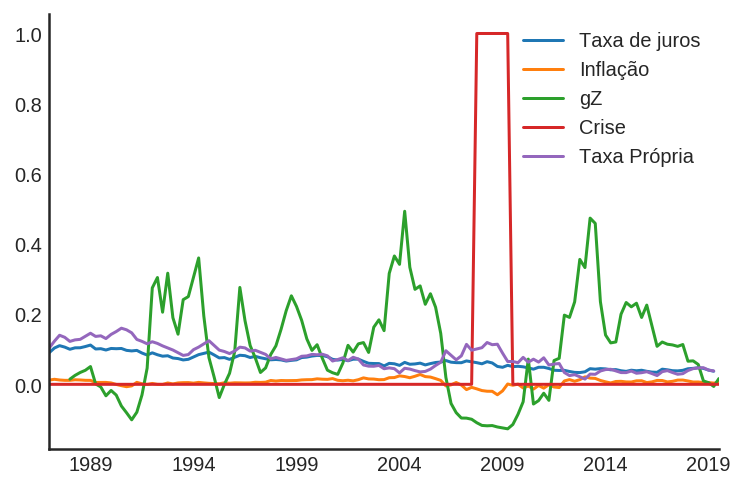

,Taxa de juros,Inflação,gZ,Crise,Taxa Própria,d_Taxa Própria,d_gZ,d_Inflação,d_Taxa de juros
,,,,,,,,,
1988-06-30,0.1040,0.012974,0.025430,0,0.126657,0.004327,0.010722,0.001635,0.0041
1988-09-30,0.1042,0.012430,0.033724,0,0.128151,0.001494,0.008294,-0.000544,0.0002
1988-12-31,0.1077,0.011398,0.039976,0,0.137036,0.008884,0.006252,-0.001032,0.0035
1989-03-31,0.1119,0.011264,0.050665,0,0.145641,0.008606,0.010689,-0.000134,0.0042
1989-06-30,0.1007,0.005247,0.001108,0,0.136518,-0.009123,-0.049557,-0.006017,-0.0112


In [3]:
df = web.DataReader(
    [
        "PRFI",
        "CSUSHPISA",
        "MORTGAGE30US",
    ], 
    'fred', 
    start, 
    end
)

df.columns = [
    "Investimento residencial", 
    "Preço dos imóveis", 
    "Taxa de juros",
]
df.index.name = ""

df['Taxa de juros'] = df['Taxa de juros'].divide(100)
df['Preço dos imóveis'] = df['Preço dos imóveis']/df['Preço dos imóveis'][0]
df["Inflação"] = df["Preço dos imóveis"].pct_change(12) # Warning: 12
#df = df.resample('Q').mean() #### Antigo
df = df.resample('Q').last()

df["Taxa Própria"] = ((1+df["Taxa de juros"])/(1+df["Inflação"])) -1
df['Taxa Própria'], *_ = yeojohnson(df['Taxa Própria'])

df['gZ'], *_ = yeojohnson(df["Investimento residencial"].pct_change(4))

df["Crise"] = [0 for i in range(len(df["gZ"]))]
for i in range(len(df["Crise"])):
    if df.index[i] > datetime.datetime(2007,12,1) and df.index[i] < datetime.datetime(2009,7,1):
        df["Crise"][i] = 1

df.to_csv("Dados_yeojohnson.csv")


df.to_csv(
    "Dados_yeojohnson_ascii.csv", 
    encoding='ascii', 
    header = [
        #'data',
        'invRes',
        'preco',
        'juros',
        'infla',
        'taxap',
        'gz',
        'crise',
          ], 
         )

df = df[["Taxa de juros", "Inflação", "gZ", "Crise", "Taxa Própria"]]
df.plot()
sns.despine()
plt.show()

df["d_Taxa Própria"] = df["Taxa Própria"].diff()
df["d_gZ"] = df["gZ"].diff()
df["d_Inflação"] = df["Inflação"].diff()
df["d_Taxa de juros"] = df['Taxa de juros'].diff()
df = df.dropna()
df.head()

# Funções

## Teste de raíz unitária

In [4]:
def testes_raiz(df=df["gZ"], original_trend='c', diff_trend='c'):
    """
    serie: Nome da coluna do df
    orignal_trend: 'c', 'ct', 'ctt'
    diff_trend: 'c', 'ct', 'ctt'
    
    Plota série o original e em diferenta e retorna testes de raíz unitária
    """
    fig, ax = plt.subplots(1,2)

    df.plot(ax=ax[0], title='série original')
    df.diff().plot(ax=ax[1], title='série em diferença')

    plt.tight_layout()
    sns.despine()
    plt.show()
    
    fig, ax = plt.subplots(2,2)
    
    plot_acf(df, ax=ax[0,0], title='ACF: serie original') 
    plot_pacf(df, ax=ax[0,1], title='PACF: serie original')
    
    plot_acf(df.diff().dropna(), ax=ax[1,0], title='ACF: serie em diferença') 
    plot_pacf(df.diff().dropna(), ax=ax[1,1], title='PACF: serie em diferença')
    
    plt.tight_layout()
    sns.despine() 
    plt.show()

    
    # Zivot Andrews
    print('\nZIVOT ANDREWS série em nível')
    print(ZivotAndrews(df, trend = original_trend).summary(),"\n")
    print('\nZIVOT ANDREWS série em primeira difenrença')
    print(ZivotAndrews(df.diff().dropna(), trend = diff_trend).summary(),"\n")
    
    print('\nADF série em nível')
    print(ADF(df, trend=original_trend).summary(),"\n")
    print('\nADF série em primeira diferença')
    print(ADF(df.diff().dropna(), trend=diff_trend).summary(),"\n")
    
    print('\nDFGLS série em nível')
    print(DFGLS(df, trend=original_trend).summary(),"\n")
    print('\nDFGLS série em primeira diferença')
    print(DFGLS(df.diff().dropna(), trend=diff_trend).summary(),"\n")
    
    print('\nKPSS em nível')
    print(KPSS(df, trend = original_trend).summary(),"\n")
    print('\nKPSS em primeira diferença')
    print(KPSS(df.diff().dropna(), trend = diff_trend).summary(),"\n")
    
    print('\nPhillips Perron em nível')
    print(PhillipsPerron(df, trend=original_trend).summary(),"\n")
    print('\nPhillips Perron em primeira diferença')
    print(PhillipsPerron(df.diff().dropna(), trend=diff_trend).summary(),"\n")

## Teste de Cointegração Engel-Granger e de Johansen

In [5]:
# Teste de cointegração

def cointegracao(ts0, ts1, signif = 0.05, lag=1):
  trends = ['nc', 'c', 'ct', 'ctt']
  for trend in trends:
    print(f"\nTestando para lag = {lag} e trend = {trend}")
    result = coint(ts0, ts1, trend = trend, maxlag=lag)
    print('Null Hypothesis: there is NO cointegration')
    print('Alternative Hypothesis: there IS cointegration')
    print('t Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    if result[1] < signif:
      print('CONCLUSION: REJECT null Hypothesis: there IS cointegration\n')
    else:
      print('CONCLUSION: FAIL to reject Null Hypothesis: there is NO cointegration\n')
    
def testes_coint(series, maxlag=8):
    for i in range(1, maxlag):
        print(50*'=')
        cointegracao(
            ts0=series.iloc[:, 0],
            ts1=series.iloc[:, 1:],
            signif=0.05,
            lag=i
        )
        print("\nTESTE DE JOHANSEN\n")
        result = select_coint_rank(endog=series, k_ar_diff=i, det_order=1) ## Warning: 1
        print(result.summary())
        print(f'Para lag = {i}, Rank = {result.rank}')
        print(10*'=')

## Análise de resíduos: Ljung-Box e Box-Pierce

In [6]:
### Resíduos

def LjungBox_Pierce(resid, signif = 0.05, boxpierce = False, k = 4):
  """
  resid = residuals df
  signif = signif. level
  """
  var = len(resid.columns)
  print("H0: autocorrelations up to lag k equal zero")
  print('H1: autocorrelations up to lag k not zero')
  print("Box-Pierce: ", boxpierce)
  
  for i in range(var):
    print("Testing for ", resid.columns[i].upper(), ". Considering a significance level of",  signif*100,"%")
    result = acorr_ljungbox(x = resid.iloc[:,i-1], lags = k, boxpierce = boxpierce)[i-1]
    conclusion = result < signif
    for j in range(k):
      print(f'p-value = {result[j]}')
      print("Reject H0 on lag " ,j+1,"? ", conclusion[j], "\n")
    print("\n")
    
def ARCH_LM(resid, signif = 0.05, autolag = 'bic'):
  """
  df = residuals df
  signif = signif. level
  """
  var = len(resid.columns)
  print("H0: Residuals are homoscedastic")
  print('H1: Residuals are heteroskedastic')
  
  for i in range(var):
    print("Testing for ", resid.columns[i].upper())
    result = het_arch(resid = resid.iloc[:,i], autolag = autolag)
    print('LM p-value: ', result[1])
    print("Reject H0? ", result[1] < signif)
    print('F p-value: ', result[3])
    print("Reject H0? ", result[3] < signif)
    print('\n')
    

def analise_residuos(results, nmax=15):
    
    residuals = pd.DataFrame(results.resid, columns = results.names)
    
    residuals.plot()
    sns.despine()
    plt.show()
    
    for serie in residuals.columns:
        sns.set_context('paper')
        fig, ax = plt.subplots(1,2, figsize=(10,8))

        plot_acf(residuals[serie], ax=ax[0], title=f'ACF Resíduo de {serie}', zero=False) 
        plot_pacf(residuals[serie], ax=ax[1], title=f'PACF Resíduo de {serie}', zero=False)
        
        plt.tight_layout()
        sns.despine() 
        plt.show()

    print('AUTOCORRELAÇÃO RESIDUAL: PORTMANTEAU\n')
    print(results.test_whiteness(nlags=nmax).summary())
    print('\nAUTOCORRELAÇÃO RESIDUAL: PORTMANTEAU AJUSTADO\n')
    print(results.test_whiteness(nlags=nmax, adjusted=True).summary())
    print('\nLJUNGBOX\n')
    LjungBox_Pierce(residuals, k = 12, boxpierce=False)
    print('\nBOXPIERCE\n')
    LjungBox_Pierce(residuals, k = 12, boxpierce=True)
    print('\nNORMALIDADE\n')
    print(results.test_normality().summary())
    print('\nHOMOCEDASTICIDADE\n')
    ARCH_LM(residuals)
    
    return residuals
    

In [7]:
results = []
def plot_lags(results = results, trimestres=[2, 5]):
    series = results.names
    fig, ax = plt.subplots(len(trimestres),2, figsize = (16,10))
    
    for i in range(len(trimestres)):
        sns.regplot(y = df[series[0]], x = df[series[1]].shift(-trimestres[i]), color = 'black', ax = ax[i,0], order = 2)
        ax[i,0].set_xlabel(f'{series[1]} defasada em {trimestres[i]} trimestres')

        sns.regplot(x = df[series[0]].shift(-trimestres[i]), y = df[series[1]], color = 'black', ax = ax[i,1], order = 2)
        ax[i,1].set_xlabel(f'{series[0]} defasada em {trimestres[i]} trimestres')

# Teste de quebra estrutural

In [8]:
%%R -i df
library(strucchange)
library(urca)
df <- df[,c(4:7)]
names(df) <- c("Juros", "Infla", "TaxaP", "gZ")
df <- ts(data = df, start = c(1987,01), frequency = 4)
bp_ts <- breakpoints(Juros ~ 1, data=df)
print("Testando quebra estrutural para Taxa de juros das hipotecas")
print(summary(bp_ts))

bp_ts <- breakpoints(gZ ~ 1, data=df)
print("=========================")
print("Testando quebra estrutural para Taxa de crescimento dos imóveis")
print(summary(bp_ts))

bp_ts <- breakpoints(TaxaP ~ 1, data=df)
print("=========================")
print("Testando quebra estrutural para Taxa Própria")
print(summary(bp_ts))

bp_ts <- breakpoints(Infla ~ 1, data=df)
print("=========================")
print("Testando quebra estrutural para Inflação")
print(summary(bp_ts))

R[write to console]: Carregando pacotes exigidos: zoo

R[write to console]: 
Attaching package: ‘zoo’


R[write to console]: The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric


R[write to console]: Carregando pacotes exigidos: sandwich



[1] "Testando quebra estrutural para Taxa de juros das hipotecas"

	 Optimal (m+1)-segment partition: 

Call:
breakpoints.formula(formula = Juros ~ 1, data = df)

Breakpoints at observation number:
                      
m = 1            78   
m = 2            67 85
m = 3   18       67 85
m = 4   18 36    67 85
m = 5   18 36 54 73 91

Corresponding to breakdates:
                                               
m = 1                           2006(2)        
m = 2                           2003(3) 2008(1)
m = 3   1991(2)                 2003(3) 2008(1)
m = 4   1991(2) 1995(4)         2003(3) 2008(1)
m = 5   1991(2) 1995(4) 2000(2) 2005(1) 2009(3)

Fit:
                                                   
m   0       1       2       3       4       5      
RSS   6.608   5.957   4.278   4.278   4.278   4.278
BIC  -3.113  -6.411 -38.155 -28.499 -18.842  -9.186
[1] "========================="
[1] "Testando quebra estrutural para Taxa de crescimento dos imÃ³veis"

	 Optimal (m+1)-segment part

Selecionando série para depois de 1991

In [9]:
df = df["1992-01-01":]

# Teste de raíz unitária

## Investimento residencial ($g_Z$)

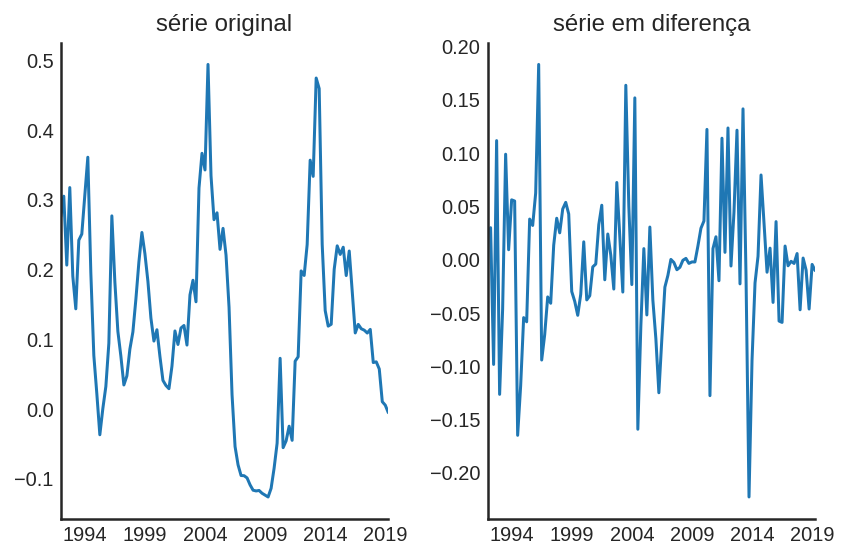

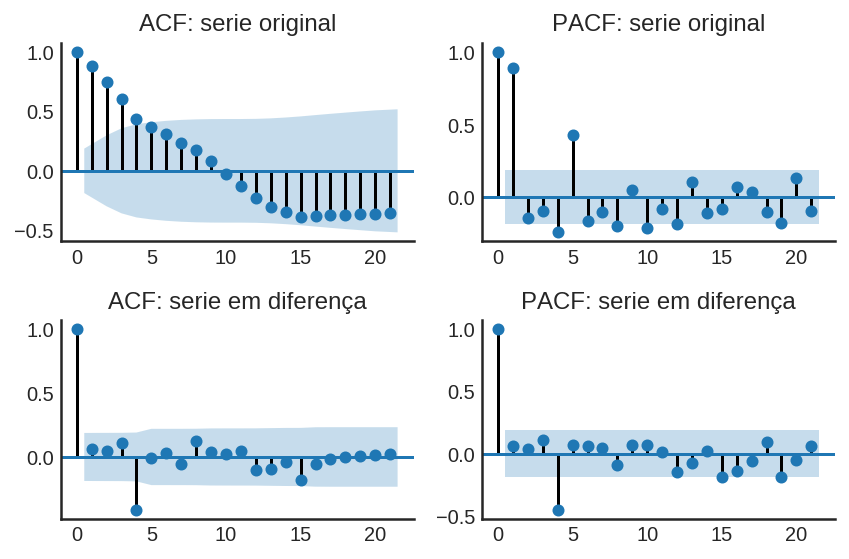


ZIVOT ANDREWS série em nível
        Zivot-Andrews Results        
Test Statistic                 -3.206
P-value                         0.838
Lags                                5
-------------------------------------

Trend: Constant
Critical Values: -5.28 (1%), -4.81 (5%), -4.57 (10%)
Null Hypothesis: The process contains a unit root with a single structural break.
Alternative Hypothesis: The process is trend and break stationary. 


ZIVOT ANDREWS série em primeira difenrença
        Zivot-Andrews Results        
Test Statistic                 -7.727
P-value                         0.000
Lags                                3
-------------------------------------

Trend: Constant
Critical Values: -5.28 (1%), -4.81 (5%), -4.57 (10%)
Null Hypothesis: The process contains a unit root with a single structural break.
Alternative Hypothesis: The process is trend and break stationary. 


ADF série em nível
   Augmented Dickey-Fuller Results   
Test Statistic                 -2.406
P-value 

In [10]:
testes_raiz(df=df['gZ'])

**Conclusão:** Série  não é fracamente estacionária.

## Taxa própria

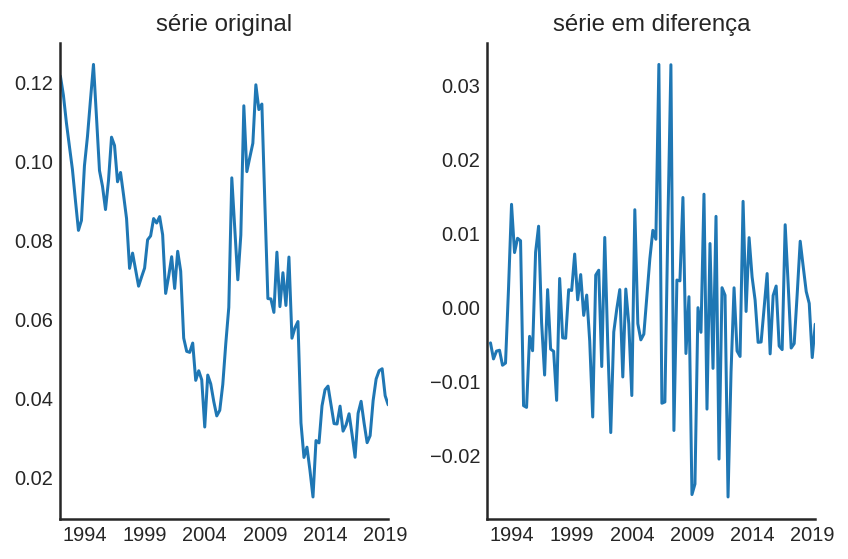

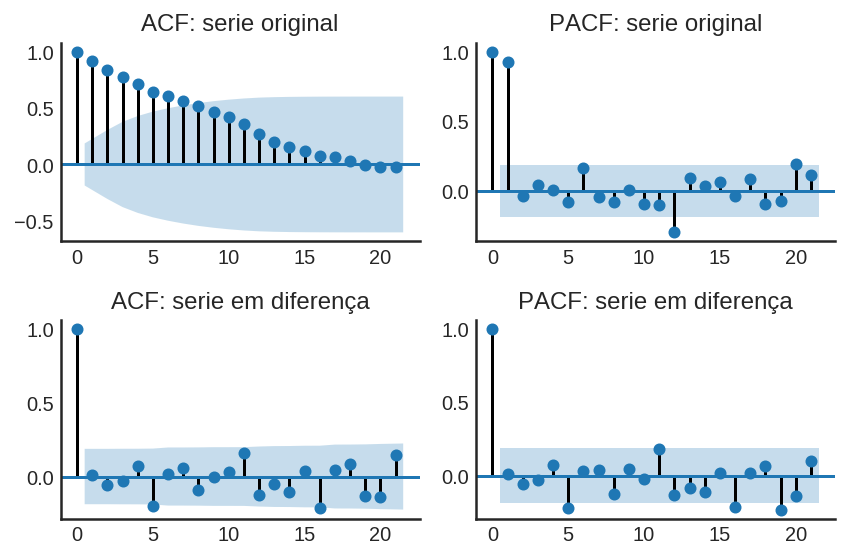


ZIVOT ANDREWS série em nível
        Zivot-Andrews Results        
Test Statistic                 -4.103
P-value                         0.291
Lags                                0
-------------------------------------

Trend: Constant
Critical Values: -5.28 (1%), -4.81 (5%), -4.57 (10%)
Null Hypothesis: The process contains a unit root with a single structural break.
Alternative Hypothesis: The process is trend and break stationary. 


ZIVOT ANDREWS série em primeira difenrença
        Zivot-Andrews Results        
Test Statistic                -10.686
P-value                         0.000
Lags                                0
-------------------------------------

Trend: Constant
Critical Values: -5.28 (1%), -4.81 (5%), -4.57 (10%)
Null Hypothesis: The process contains a unit root with a single structural break.
Alternative Hypothesis: The process is trend and break stationary. 


ADF série em nível
   Augmented Dickey-Fuller Results   
Test Statistic                 -2.212
P-value 

In [11]:
testes_raiz(df['Taxa Própria'])

**Conclusão:** Será tomada em primeira diferença.

## Inflação

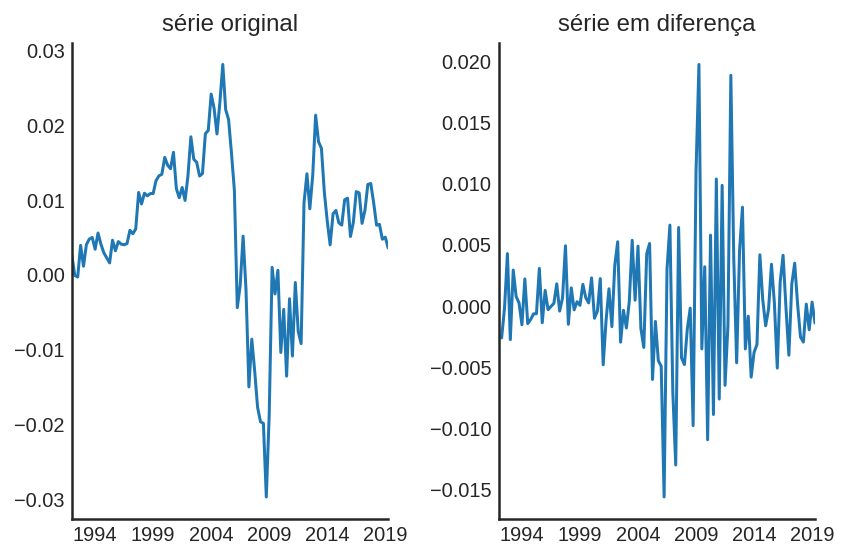

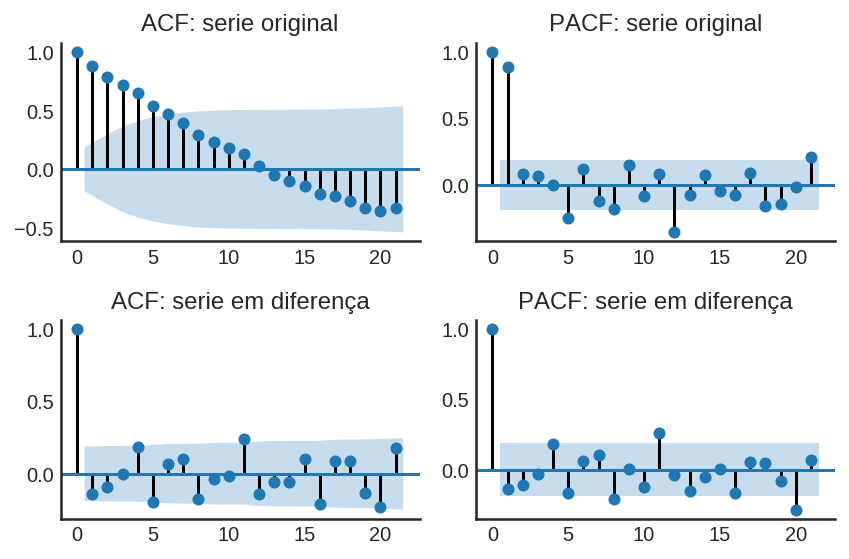


ZIVOT ANDREWS série em nível
        Zivot-Andrews Results        
Test Statistic                 -4.891
P-value                         0.041
Lags                               11
-------------------------------------

Trend: Constant
Critical Values: -5.28 (1%), -4.81 (5%), -4.57 (10%)
Null Hypothesis: The process contains a unit root with a single structural break.
Alternative Hypothesis: The process is trend and break stationary. 


ZIVOT ANDREWS série em primeira difenrença
        Zivot-Andrews Results        
Test Statistic                -12.705
P-value                         0.000
Lags                                0
-------------------------------------

Trend: Constant
Critical Values: -5.28 (1%), -4.81 (5%), -4.57 (10%)
Null Hypothesis: The process contains a unit root with a single structural break.
Alternative Hypothesis: The process is trend and break stationary. 


ADF série em nível
   Augmented Dickey-Fuller Results   
Test Statistic                 -2.665
P-value 

In [12]:
testes_raiz(df['Inflação'])

## Taxa de juros das hipotecas

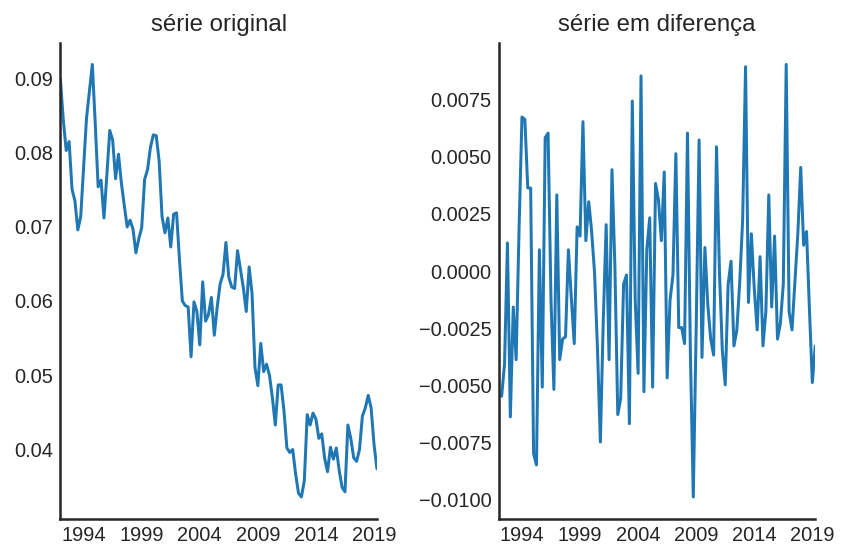

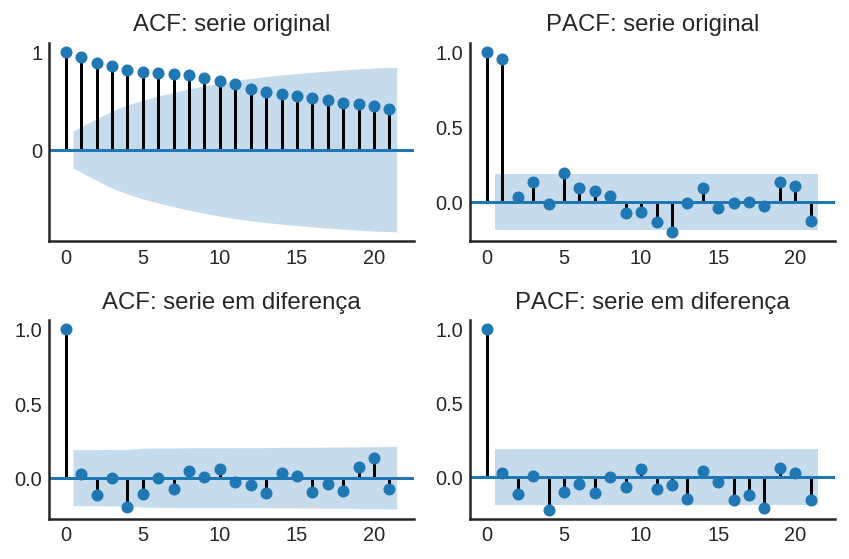


ZIVOT ANDREWS série em nível
        Zivot-Andrews Results        
Test Statistic                 -4.494
P-value                         0.215
Lags                                0
-------------------------------------

Trend: Constant and Linear Time Trend
Critical Values: -5.58 (1%), -5.07 (5%), -4.83 (10%)
Null Hypothesis: The process contains a unit root with a single structural break.
Alternative Hypothesis: The process is trend and break stationary. 


ZIVOT ANDREWS série em primeira difenrença
        Zivot-Andrews Results        
Test Statistic                 -8.144
P-value                         0.000
Lags                                1
-------------------------------------

Trend: Constant
Critical Values: -5.28 (1%), -4.81 (5%), -4.57 (10%)
Null Hypothesis: The process contains a unit root with a single structural break.
Alternative Hypothesis: The process is trend and break stationary. 


ADF série em nível
   Augmented Dickey-Fuller Results   
Test Statistic          

In [13]:
testes_raiz(df['Taxa de juros'], original_trend='ct')

# Cointegração

## $g_Z$ e Taxa Própria

In [14]:
print("Ordem do VAR\n")

model = VAR(
    df[["gZ", 'Taxa Própria']],
)
print(model.select_order(maxlags=15, trend='ct').summary())

testes_coint(series=df[['gZ', 'Taxa Própria']], maxlag=9)

Ordem do VAR

 VAR Order Selection (* highlights the minimums)  
       AIC         BIC         FPE         HQIC   
--------------------------------------------------
0       -12.60      -12.49   3.382e-06      -12.55
1       -14.97     -14.75*   3.162e-07     -14.88*
2       -14.95      -14.62   3.230e-07      -14.82
3       -14.91      -14.48   3.366e-07      -14.73
4       -14.95      -14.41   3.227e-07      -14.73
5       -15.03      -14.38   2.981e-07      -14.77
6      -15.04*      -14.29  2.938e-07*      -14.74
7       -15.02      -14.16   3.030e-07      -14.67
8       -14.96      -14.00   3.201e-07      -14.57
9       -14.91      -13.84   3.377e-07      -14.48
10      -14.85      -13.67   3.607e-07      -14.37
11      -14.80      -13.51   3.807e-07      -14.28
12      -14.82      -13.42   3.769e-07      -14.26
13      -14.74      -13.24   4.103e-07      -14.13
14      -14.68      -13.07   4.409e-07      -14.03
15      -14.73      -13.01   4.215e-07      -14.04
-----------------

Null Hypothesis: there is NO cointegration
Alternative Hypothesis: there IS cointegration
t Statistic: -2.467834
p-value: 0.098238
CONCLUSION: FAIL to reject Null Hypothesis: there is NO cointegration


Testando para lag = 7 e trend = c
Null Hypothesis: there is NO cointegration
Alternative Hypothesis: there IS cointegration
t Statistic: -2.046307
p-value: 0.504439
CONCLUSION: FAIL to reject Null Hypothesis: there is NO cointegration


Testando para lag = 7 e trend = ct
Null Hypothesis: there is NO cointegration
Alternative Hypothesis: there IS cointegration
t Statistic: -3.614543
p-value: 0.076004
CONCLUSION: FAIL to reject Null Hypothesis: there is NO cointegration


Testando para lag = 7 e trend = ctt
Null Hypothesis: there is NO cointegration
Alternative Hypothesis: there IS cointegration
t Statistic: -3.833598
p-value: 0.109573
CONCLUSION: FAIL to reject Null Hypothesis: there is NO cointegration


TESTE DE JOHANSEN

Johansen cointegration test using trace test statistic with 5% s

## $g_Z$, Inflação e taxa de juros

In [15]:
testes_coint(series=df[['gZ', 'Inflação', 'Taxa de juros']])


Testando para lag = 1 e trend = nc
Null Hypothesis: there is NO cointegration
Alternative Hypothesis: there IS cointegration
t Statistic: -4.013702
p-value: 0.006120
CONCLUSION: REJECT null Hypothesis: there IS cointegration


Testando para lag = 1 e trend = c
Null Hypothesis: there is NO cointegration
Alternative Hypothesis: there IS cointegration
t Statistic: -4.104295
p-value: 0.018110
CONCLUSION: REJECT null Hypothesis: there IS cointegration


Testando para lag = 1 e trend = ct
Null Hypothesis: there is NO cointegration
Alternative Hypothesis: there IS cointegration
t Statistic: -5.378409
p-value: 0.000693
CONCLUSION: REJECT null Hypothesis: there IS cointegration


Testando para lag = 1 e trend = ctt
Null Hypothesis: there is NO cointegration
Alternative Hypothesis: there IS cointegration
t Statistic: -5.511844
p-value: 0.001477
CONCLUSION: REJECT null Hypothesis: there IS cointegration


TESTE DE JOHANSEN

Johansen cointegration test using trace test statistic with 5% significa

## $g_Z$ e Inflação

In [16]:
testes_coint(series=df[['gZ', 'Inflação']])


Testando para lag = 1 e trend = nc
Null Hypothesis: there is NO cointegration
Alternative Hypothesis: there IS cointegration
t Statistic: -4.126271
p-value: 0.000679
CONCLUSION: REJECT null Hypothesis: there IS cointegration


Testando para lag = 1 e trend = c
Null Hypothesis: there is NO cointegration
Alternative Hypothesis: there IS cointegration
t Statistic: -4.107310
p-value: 0.005019
CONCLUSION: REJECT null Hypothesis: there IS cointegration


Testando para lag = 1 e trend = ct
Null Hypothesis: there is NO cointegration
Alternative Hypothesis: there IS cointegration
t Statistic: -4.102942
p-value: 0.020272
CONCLUSION: REJECT null Hypothesis: there IS cointegration


Testando para lag = 1 e trend = ctt
Null Hypothesis: there is NO cointegration
Alternative Hypothesis: there IS cointegration
t Statistic: -4.091155
p-value: 0.058926
CONCLUSION: FAIL to reject Null Hypothesis: there is NO cointegration


TESTE DE JOHANSEN

Johansen cointegration test using trace test statistic with 5

# VECM

VECM: $g_Z$, Inflação e Juros exógeno

## Ordem do modelo

In [17]:
from statsmodels.tsa.vector_ar.vecm import select_order

#det = 'cili'
#det = 'coli'
#det = 'colo'
#det = 'cilo'
det = 'ci'

order_vec = select_order(
    df[[
        #"Inflação", 
        "Taxa Própria", 
        "gZ"
    ]], 
    #exog=df[["Taxa de juros"]],
    maxlags=15, deterministic=det)

with open('./tabs/VECM_lag_order.tex','w') as fh:
    fh.write(order_vec.summary().as_latex_tabular(tile = "Selação ordem do VECM"))

order_vec.summary()

,AIC,BIC,FPE,HQIC
0,-14.71,-14.49*,4.091e-07,-14.62
1,-14.66,-14.34,4.291e-07,-14.53
2,-14.67,-14.24,4.259e-07,-14.50
3,-14.69,-14.15,4.176e-07,-14.47
4,-14.86,-14.21,3.545e-07,-14.59
5,-14.94*,-14.18,3.267e-07*,-14.63*
6,-14.90,-14.04,3.397e-07,-14.55
7,-14.83,-13.86,3.655e-07,-14.44
8,-14.81,-13.72,3.767e-07,-14.37
9,-14.75,-13.56,4.003e-07,-14.27


## Estimação

Det. terms outside the coint. relation & lagged endog. parameters for equation Taxa Própria
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
L1.Taxa Própria     0.0035      0.099      0.036      0.972      -0.190       0.197
L1.gZ              -0.0087      0.019     -0.463      0.643      -0.046       0.028
L2.Taxa Própria    -0.0653      0.096     -0.679      0.497      -0.254       0.123
L2.gZ            8.168e-05      0.016      0.005      0.996      -0.030       0.030
L3.Taxa Própria    -0.0357      0.104     -0.345      0.730      -0.239       0.167
L3.gZ               0.0050      0.015      0.335      0.738      -0.024       0.034
L4.Taxa Própria     0.0966      0.105      0.921      0.357      -0.109       0.302
L4.gZ              -0.0278      0.014     -1.921      0.055      -0.056       0.001
L5.Taxa Própria    -0.1898      0.105     -1.804      0.071      -0.

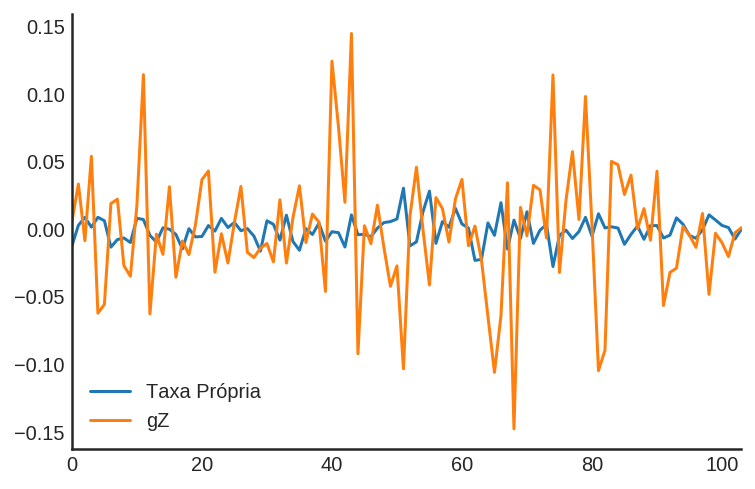

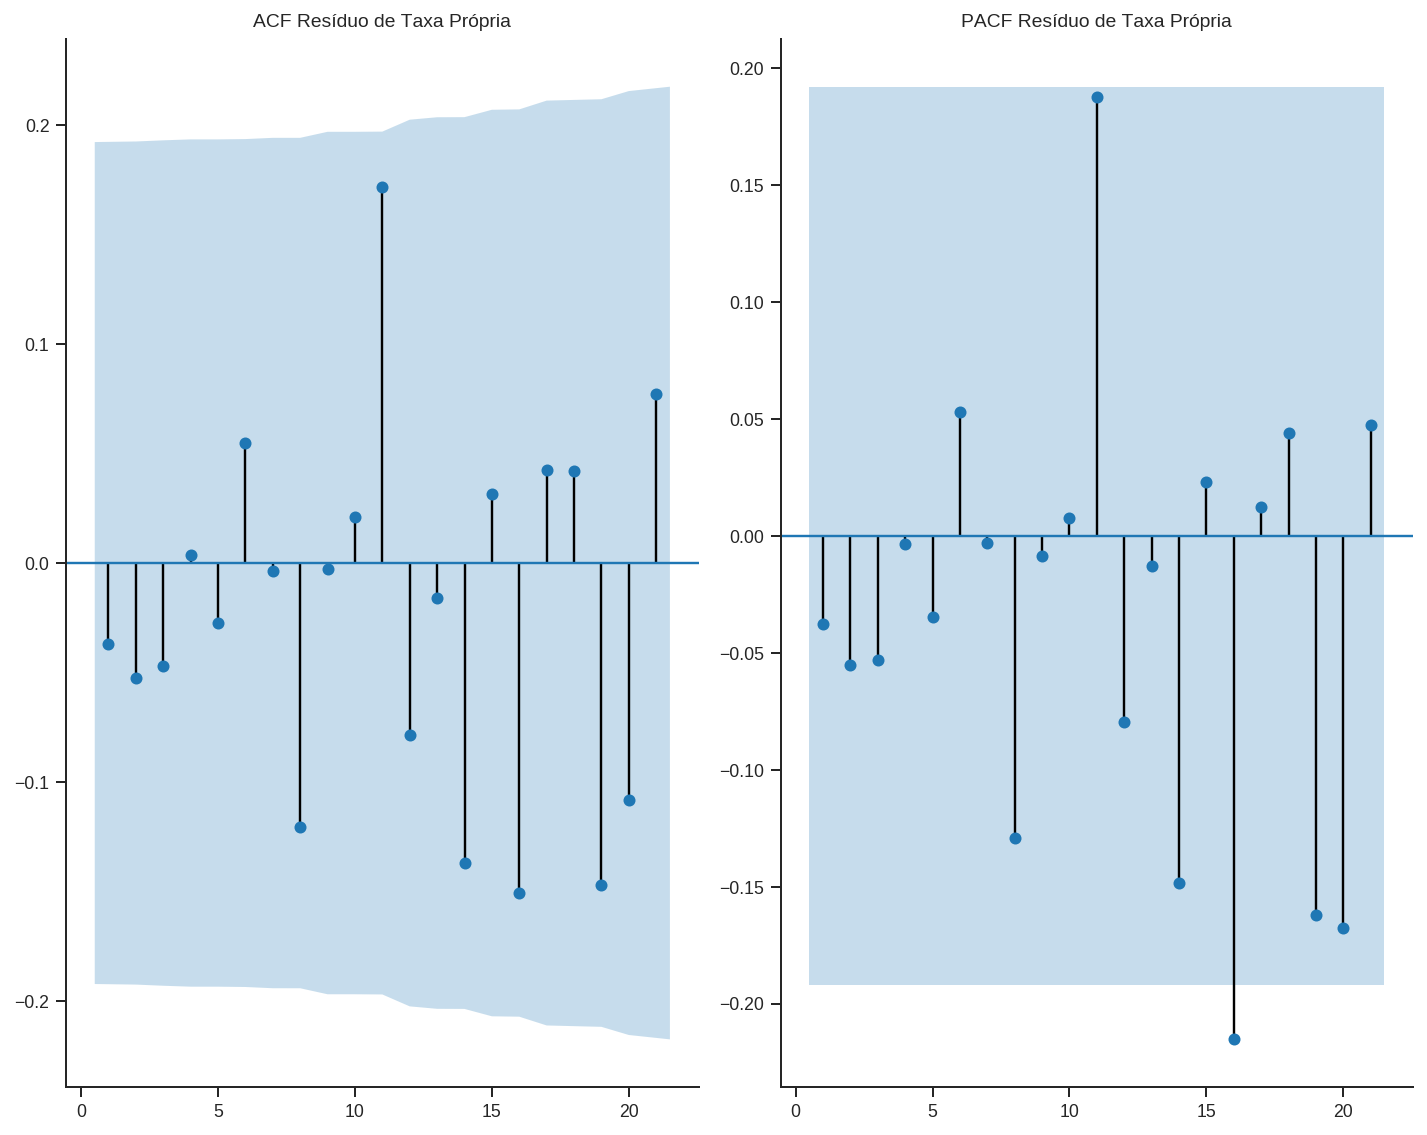

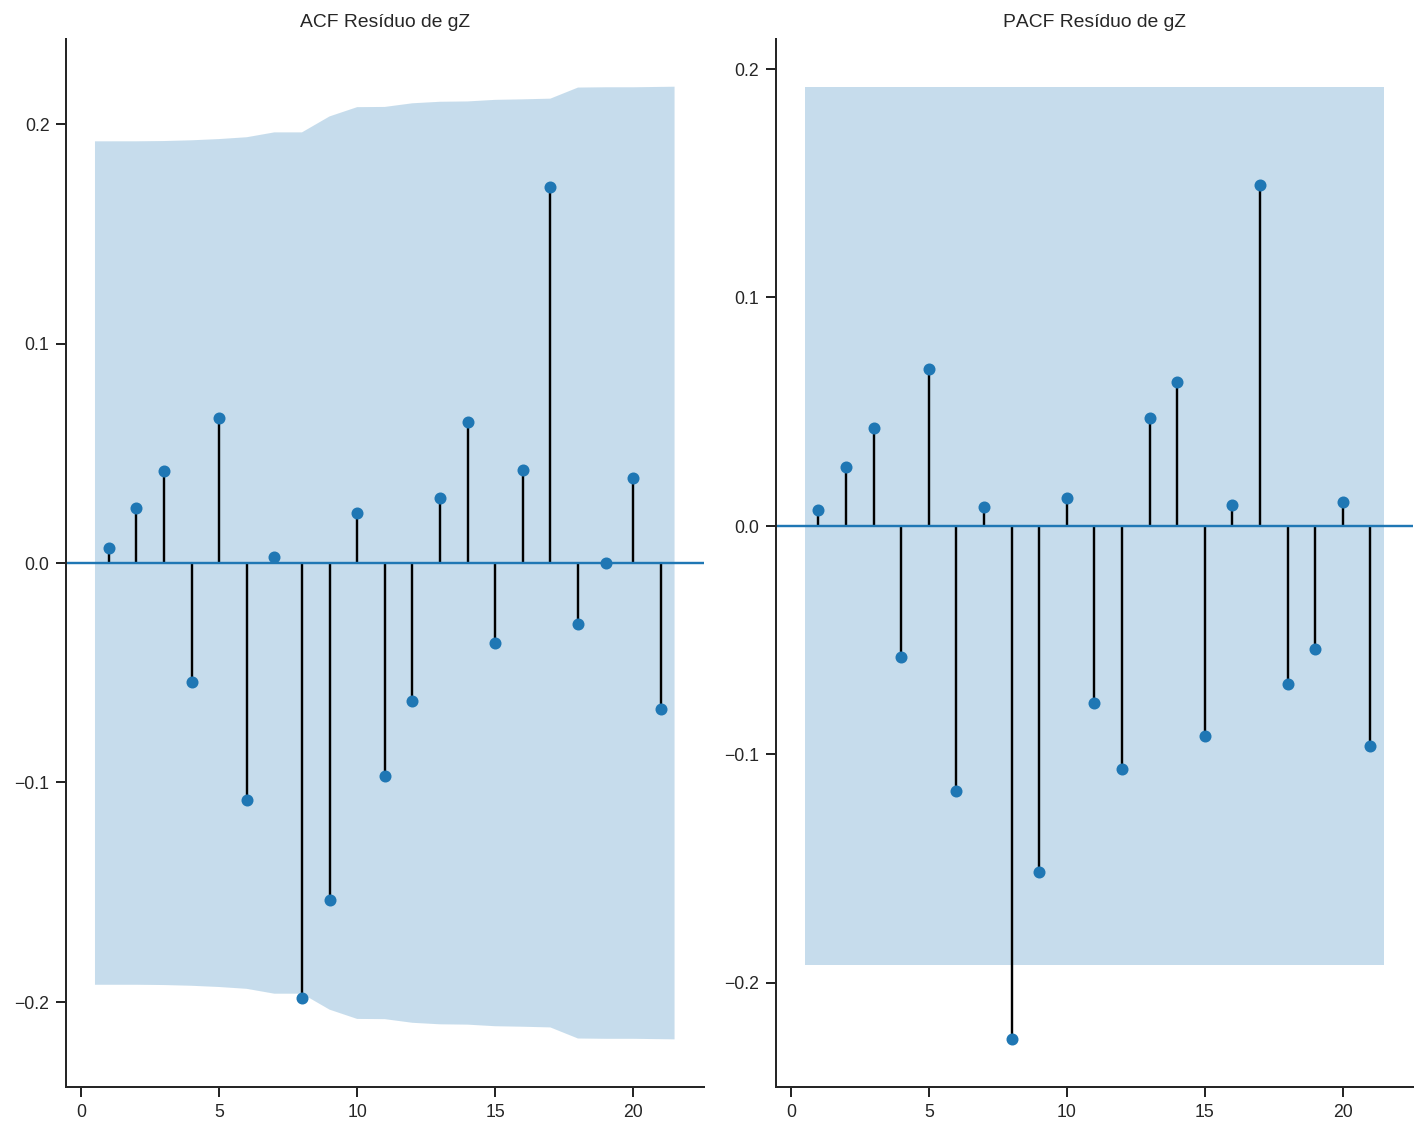

AUTOCORRELAÇÃO RESIDUAL: PORTMANTEAU

Portmanteau-test for residual autocorrelation. H_0: residual autocorrelation up to lag 15 is zero. Conclusion: fail to reject H_0 at 5% significance level.
Test statistic Critical value p-value df
----------------------------------------
         38.89          53.38   0.429 38
----------------------------------------

AUTOCORRELAÇÃO RESIDUAL: PORTMANTEAU AJUSTADO

Adjusted Portmanteau-test for residual autocorrelation. H_0: residual autocorrelation up to lag 15 is zero. Conclusion: fail to reject H_0 at 5% significance level.
Test statistic Critical value p-value df
----------------------------------------
         43.10          53.38   0.262 38
----------------------------------------

LJUNGBOX

H0: autocorrelations up to lag k equal zero
H1: autocorrelations up to lag k not zero
Box-Pierce:  False
Testing for  TAXA PRÓPRIA . Considering a significance level of 5.0 %
p-value = 0.945052519831286
Reject H0 on lag  1 ?  False 

p-value = 0.96408239

In [18]:
model = VECM(
    endog = df[[
        #"Inflação", 
        "Taxa Própria", 
        "gZ"
    ]], 
    #exog=df[["Taxa de juros"]],
    #k_ar_diff=1,
    #k_ar_diff=2,
    #k_ar_diff=3,
    #k_ar_diff=4,
    k_ar_diff=5,
    #k_ar_diff=6,
    #k_ar_diff=7,
    #k_ar_diff=8,
    deterministic=det, 
)
results = model.fit()

with open('./tabs/VECM_ajuste.tex','w') as fh:
    fh.write(results.summary().as_latex())

print(results.summary())

print(60*"=")
print("\nPÓS ESTIMAÇÂO\n")
residuals = analise_residuos(results=results)
print(60*"=")

## Função impulso resposta ortogonalizada

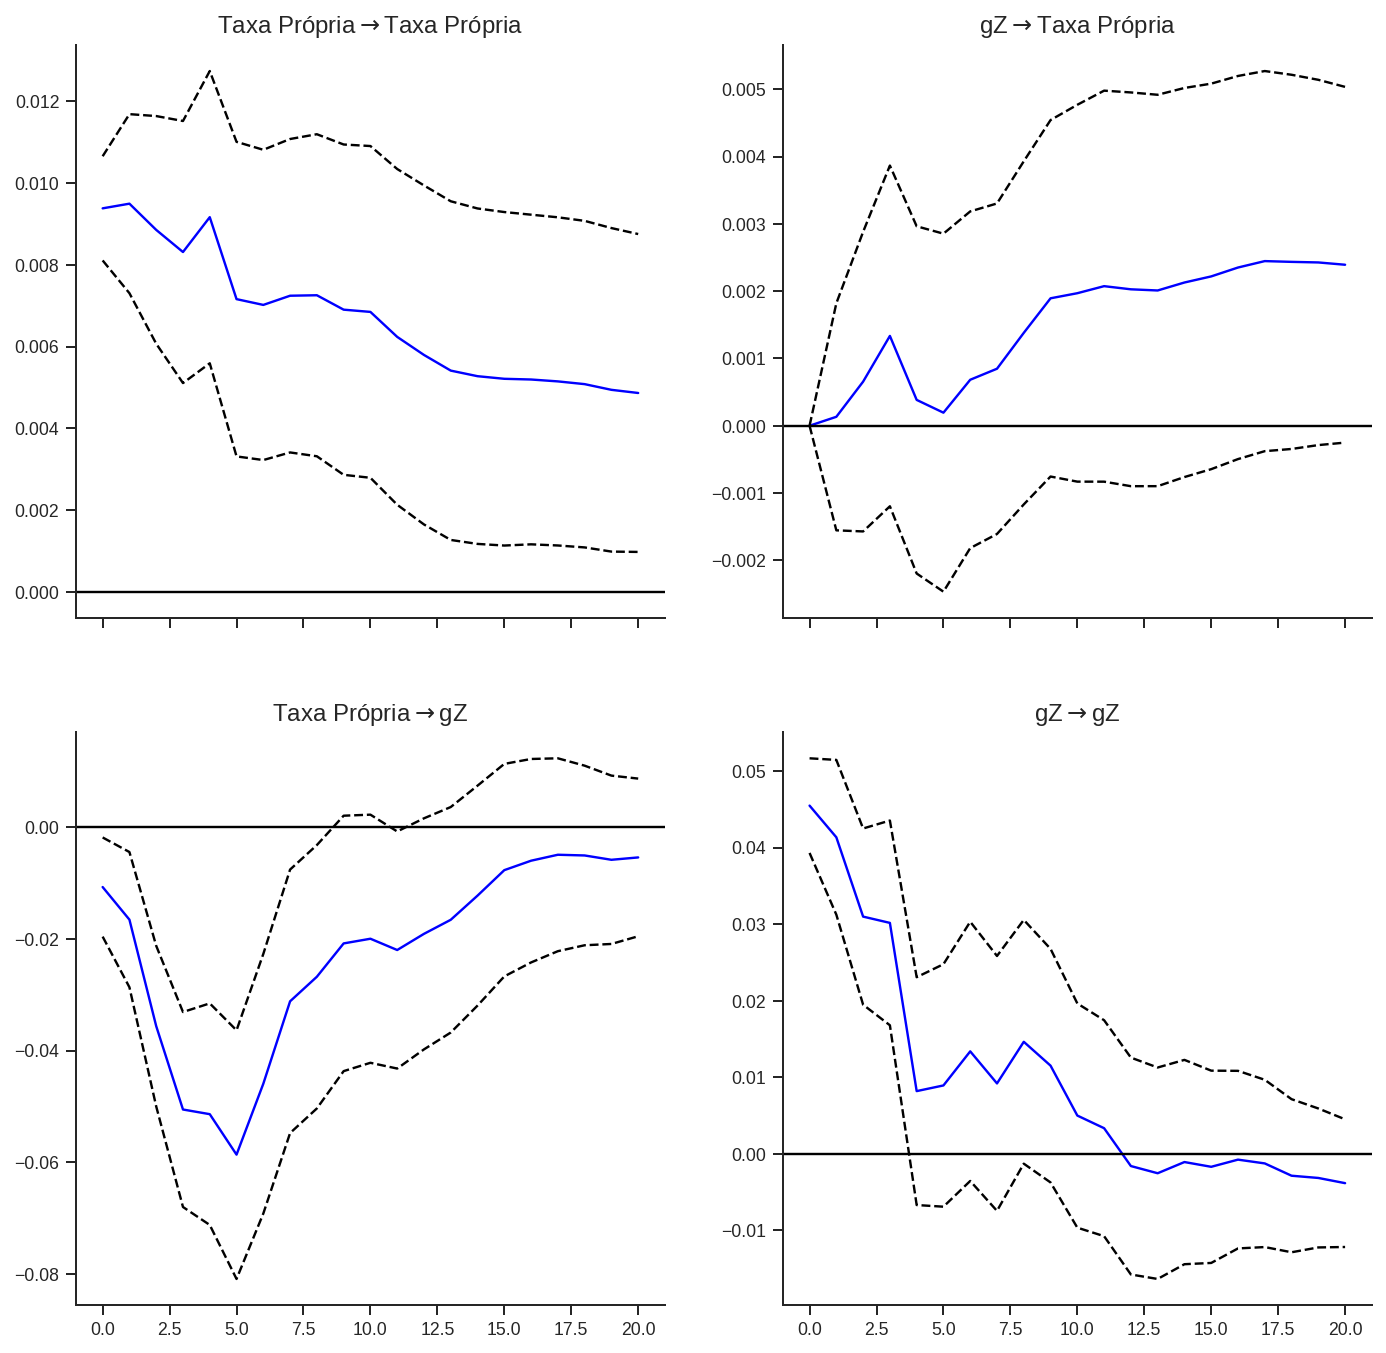

In [19]:
p = results.irf(20).plot(orth=True)
p.suptitle("")
sns.despine()
plt.show()
p.savefig("./figs/Impulso_VECMOrth.png", dpi = 300, bbox_inches = 'tight',
    pad_inches = 0.2, transparent = True,)

## Função impulso resposta não-ortogonalizada

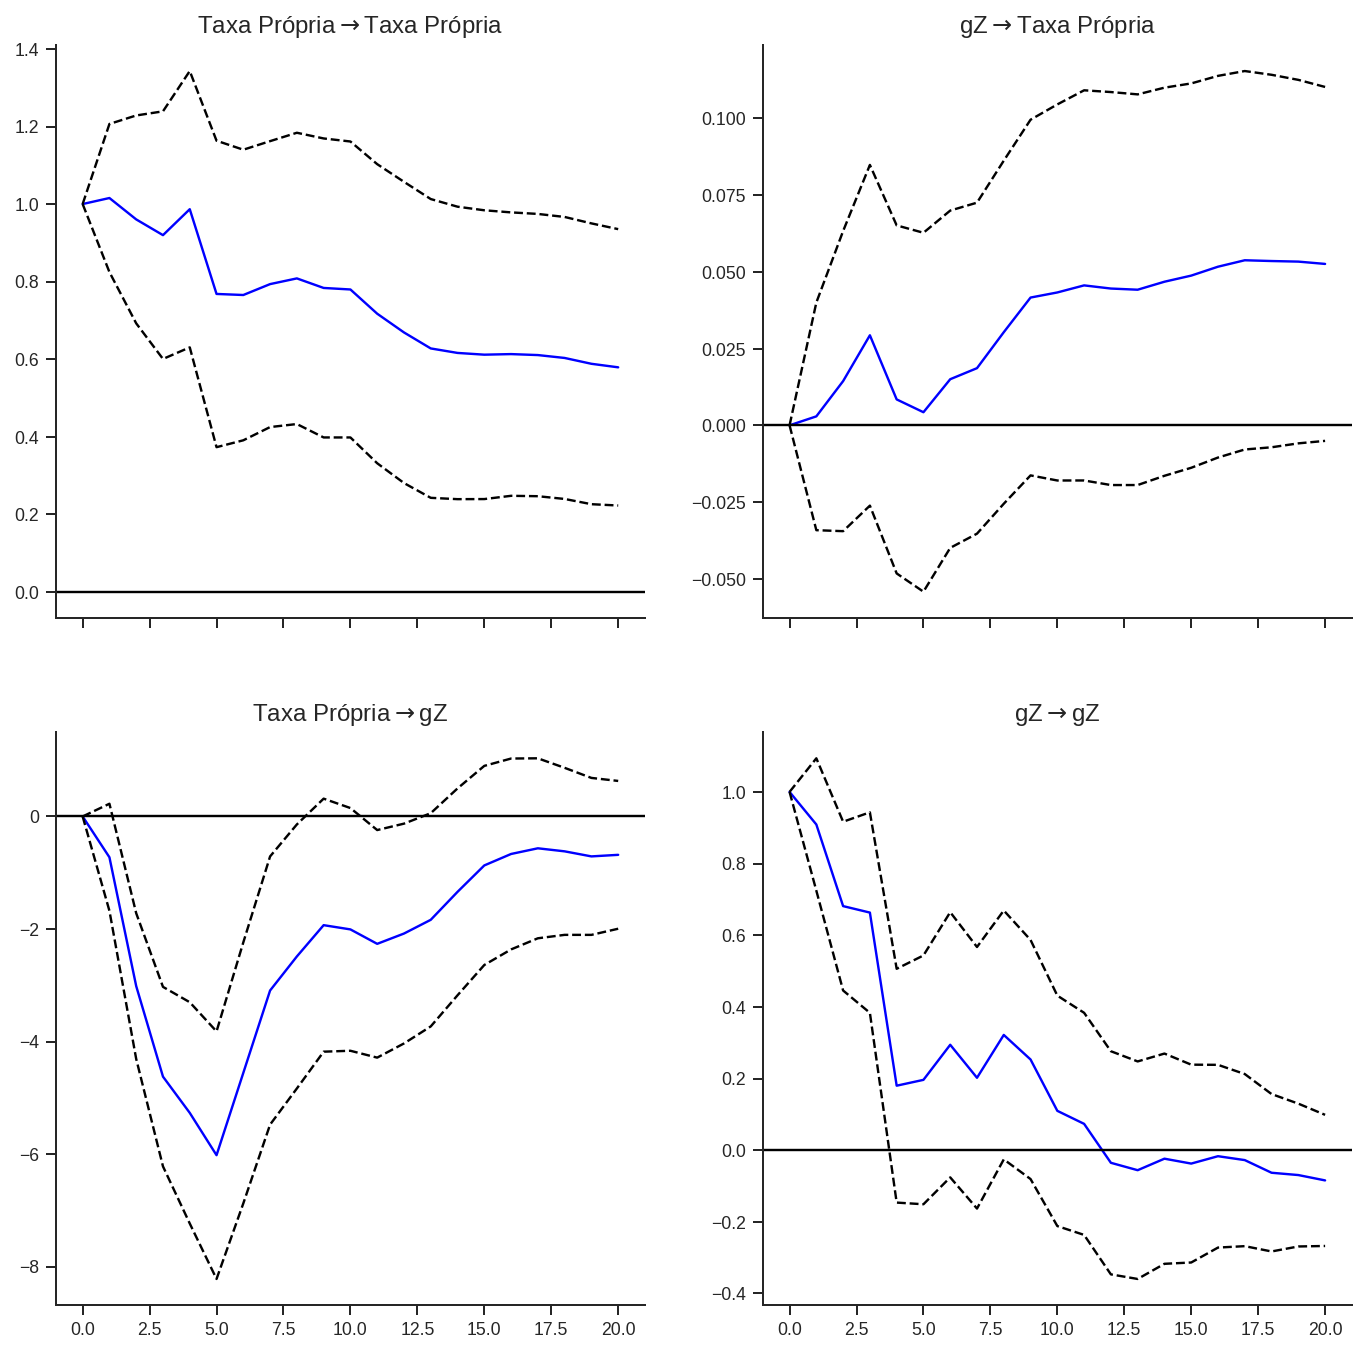

In [20]:
p = results.irf(20).plot(orth=False)
p.suptitle("")
sns.despine()
plt.show()
p.savefig("./figs/Impulso_VECM.png", dpi = 300, bbox_inches = 'tight',
    pad_inches = 0.2, transparent = True,)

## Teste de causalidade de granger

In [21]:
series = residuals.columns
print(results.test_granger_causality(causing=series[0], caused=series[1]).summary())
print(results.test_inst_causality(causing=series[0]).summary())

Granger causality F-test. H_0: Taxa Própria does not Granger-cause gZ. Conclusion: reject H_0 at 5% significance level.
Test statistic Critical value p-value    df   
----------------------------------------------
         6.451          2.150   0.000 (6, 176)
----------------------------------------------
Instantaneous causality Wald-test. H_0: Taxa Própria does not instantaneously cause gZ. Conclusion: reject H_0 at 5% significance level.
Test statistic Critical value p-value df
----------------------------------------
         5.890          3.841   0.015  1
----------------------------------------


## Inspeção gráfica dos resíduos

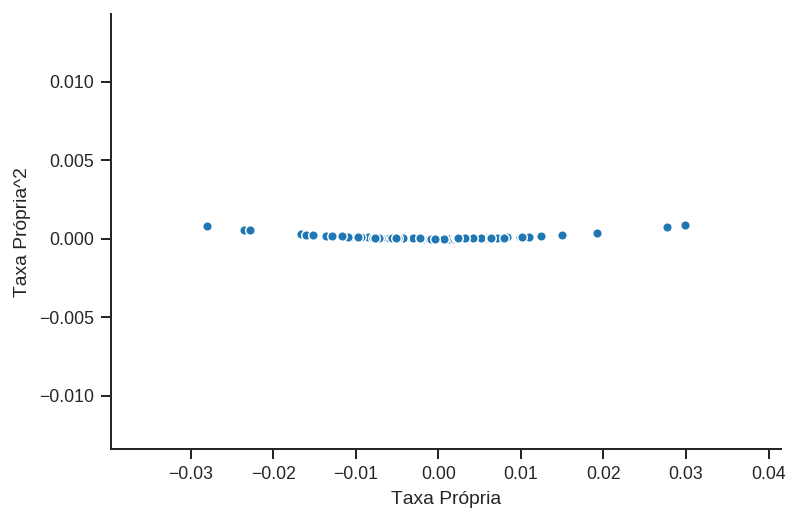

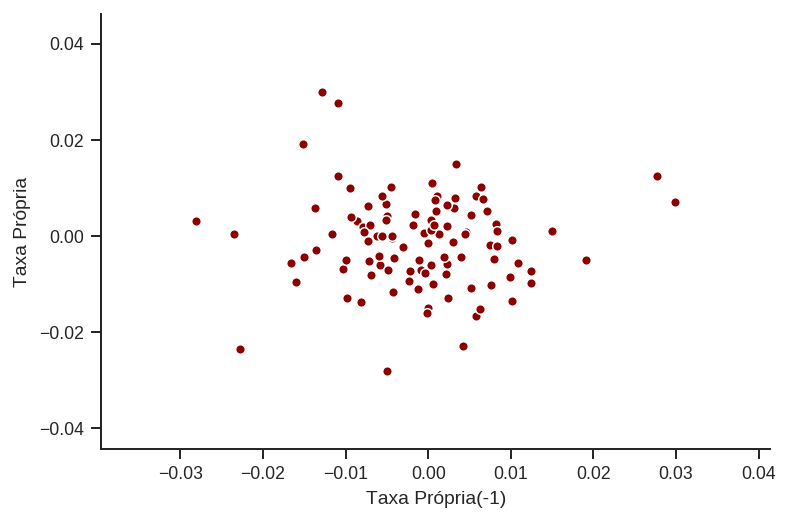

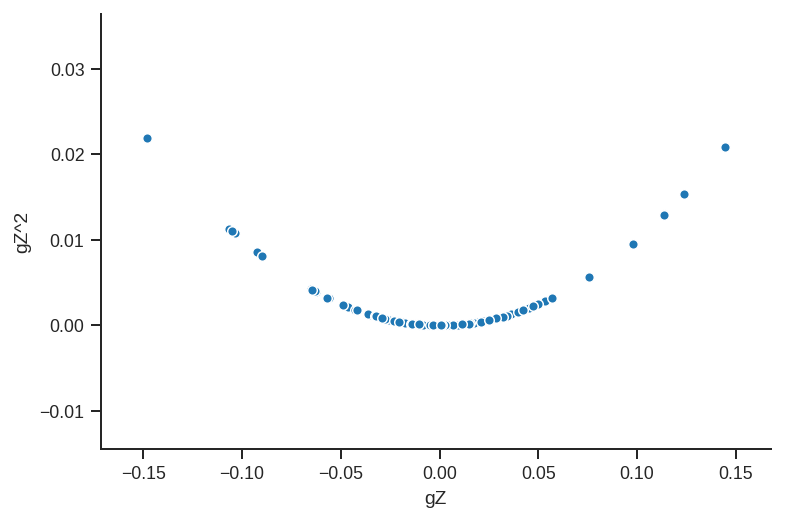

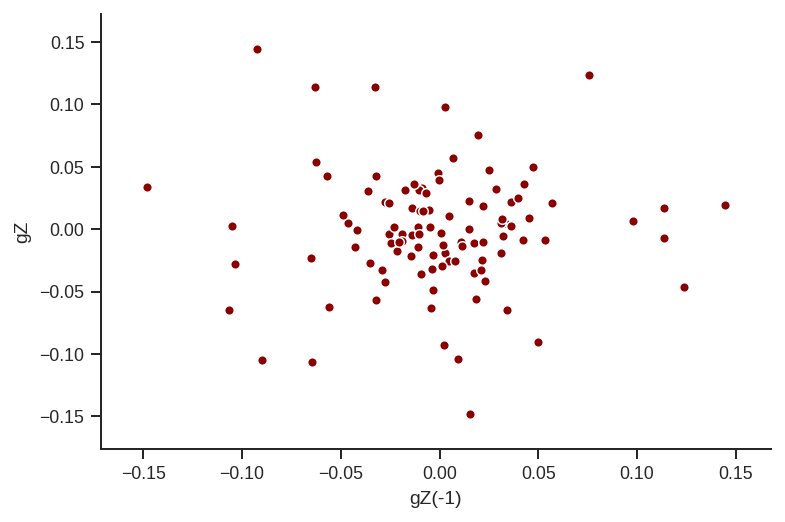

In [22]:
series = results.names
for serie in series:
    sns.scatterplot(x = residuals[serie], y = residuals[serie]**2)
    plt.ylabel(f"{serie}^2")
    sns.despine()
    plt.show()
    
    sns.scatterplot(
    y = residuals[serie], 
    x = residuals[serie].shift(-1), 
    color = 'darkred' 
    )
    sns.despine()
    plt.xlabel(f"{serie}(-1)")
    plt.show()

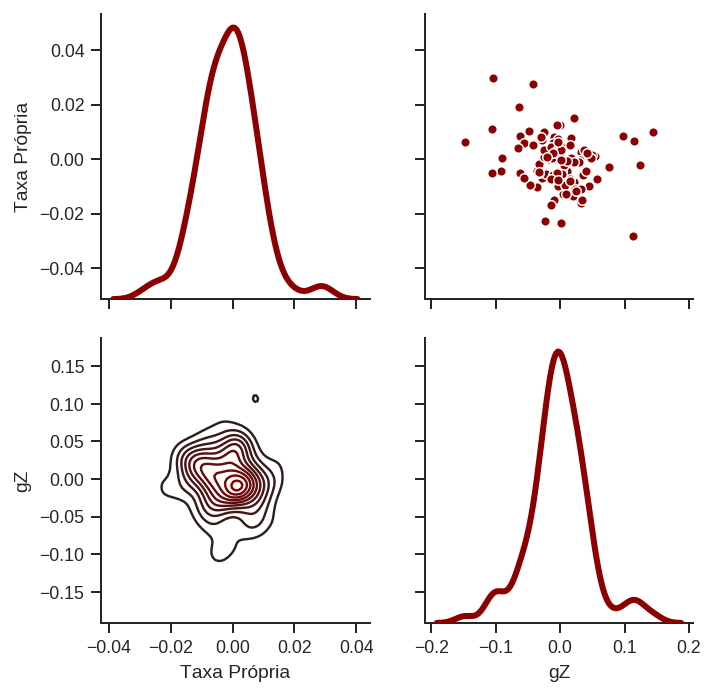

In [23]:
sns.set_context('paper')
g = sns.PairGrid(residuals, diag_sharey=False)
g.map_lower(sns.kdeplot, color = 'darkred')
g.map_upper(sns.scatterplot, color = 'darkred')
g.map_diag(sns.kdeplot, lw=3, color = 'darkred')
plt.show()
g.savefig("./figs/Residuos_4VECM.png", dpi = 300, bbox_inches = 'tight',
    pad_inches = 0.2, transparent = True,)

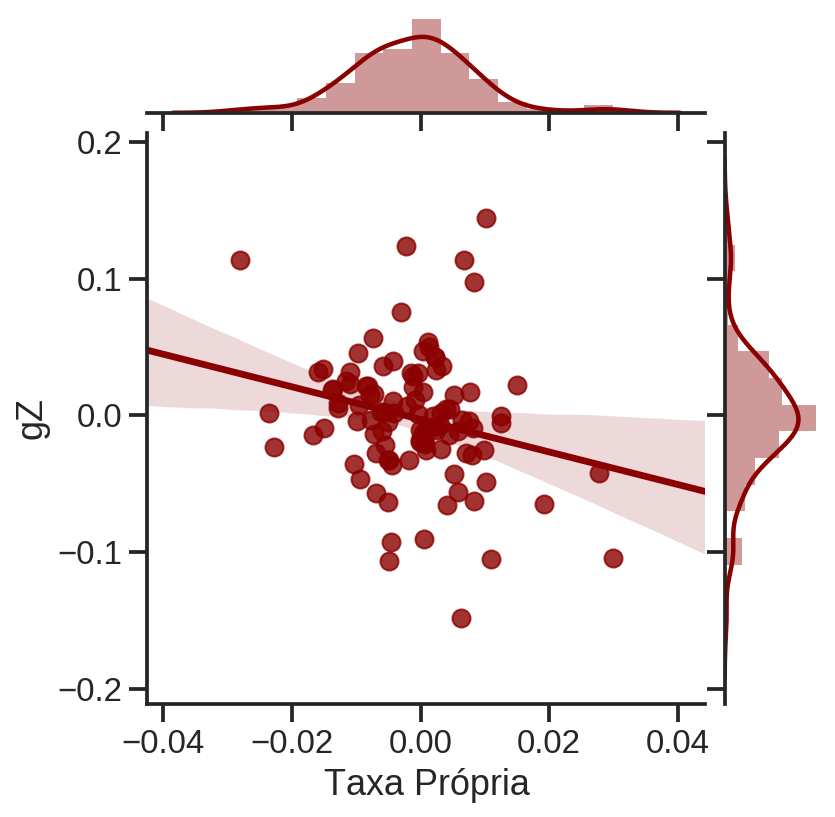

In [24]:
series = results.names
sns.set_context('talk')
ax = sns.jointplot(
    x = series[0], 
    y = series[1], 
    data = residuals, color = 'darkred', kind="reg", 
)
plt.show()

## FEVD

In [25]:
%%R -o fevd_gz
library(tsDyn)
library(readr)
df <- read.csv("./Dados_yeojohnson.csv", encoding="UTF-8")
df <- df[,c(4:7)]
names(df) <- c("Juros", "Infla", "TaxaP", "gZ")
df <- na.omit(df[,c("Juros", "Infla","TaxaP", "gZ")])
df <- ts(data = df, start = c(1992,03), frequency = 4)
model <- tsDyn::VECM(data = df[,c("TaxaP","gZ")], lag = 5, r = 1, estim = "ML", LRinclude="const", include="none")
fevd_gz = data.frame(tsDyn::fevd(model, 20)$gZ)

R[write to console]: Registered S3 method overwritten by 'xts':
  method     from
  as.zoo.xts zoo 

R[write to console]: Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 

R[write to console]: Registered S3 methods overwritten by 'forecast':
  method             from    
  fitted.fracdiff    fracdiff
  residuals.fracdiff fracdiff



In [26]:
%%R -o fevd_tx
fevd_tx = data.frame(tsDyn::fevd(model, 20)$TaxaP)

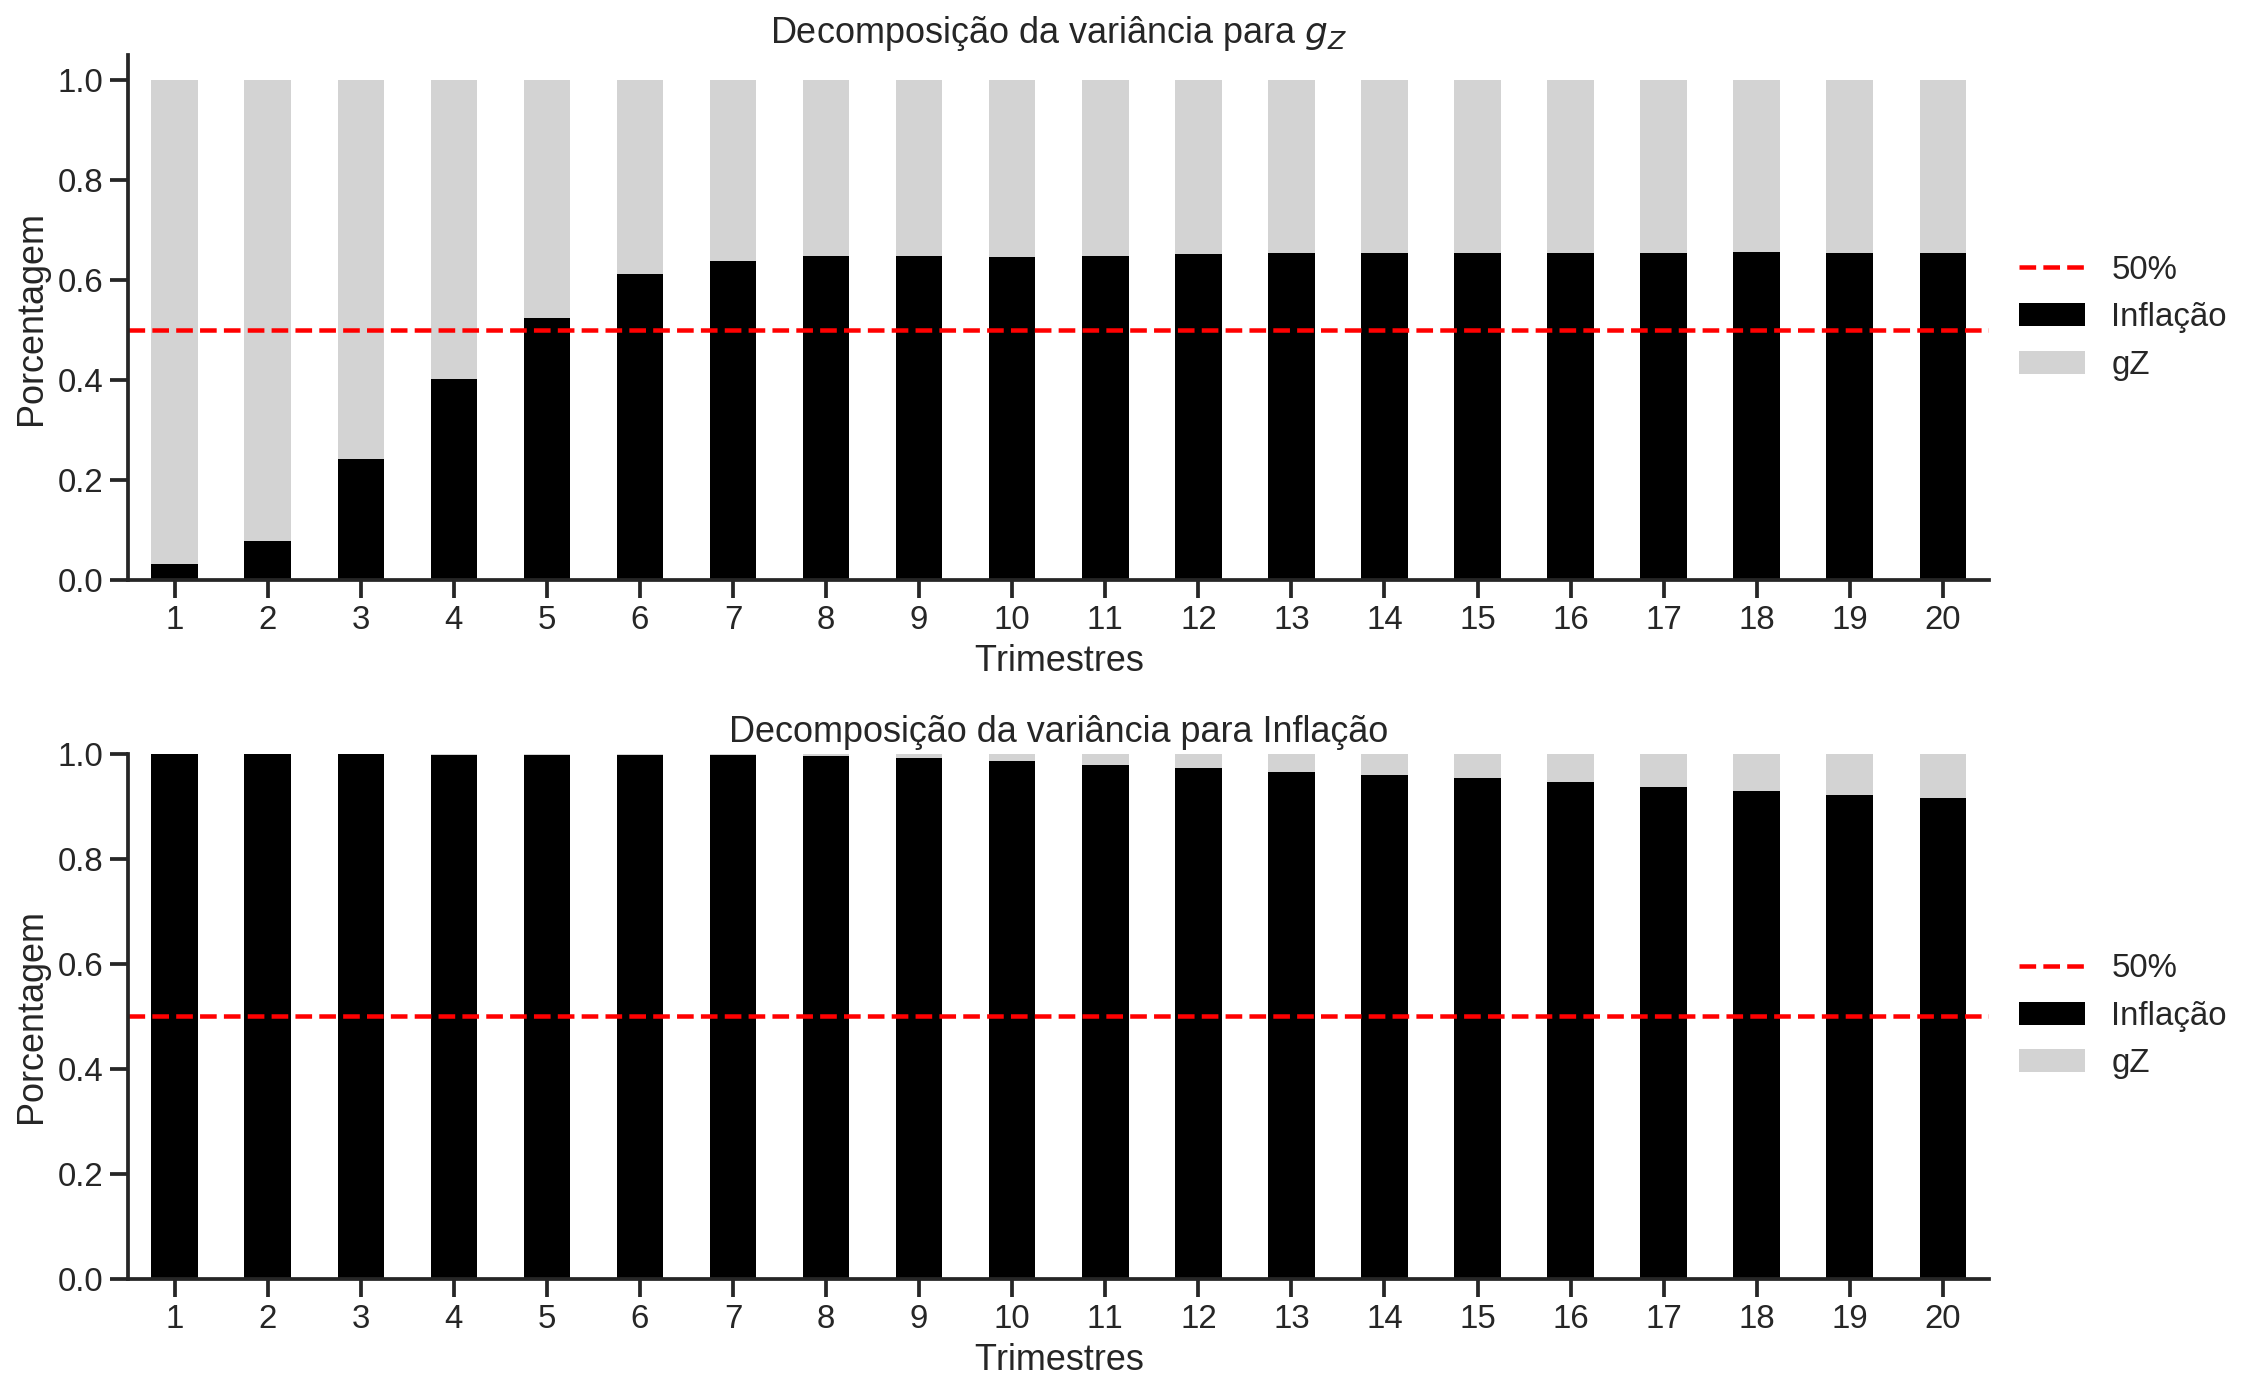

In [27]:
sns.set_context('talk')
fig, ax = plt.subplots(2,1, figsize = (16,10))

fevd_gz.plot(
    ax=ax[0], 
    title = "Decomposição da variância para $g_Z$", 
    color = ("black", "lightgray"), 
    kind = 'bar', stacked = True
)
ax[0].set_xlabel('Trimestres')
ax[0].set_ylabel('Porcentagem')
ax[0].axhline(y=0.5, color = 'red', ls = '--')
ax[0].legend(loc='center left', bbox_to_anchor=(1, 0.5), labels = ("50%", "Inflação", "gZ"))
ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=0)


fevd_tx.plot(
    ax=ax[1], 
    title = "Decomposição da variância para Inflação", 
    color = ("black", "lightgray"), 
    kind = 'bar', stacked = True,
)
ax[1].axhline(y=0.5, color = 'red', ls = '--')
ax[1].legend(loc='center left', bbox_to_anchor=(1, 0.5), labels = ("50%", "Inflação", "gZ"))
ax[1].set_xlabel('Trimestres')
ax[1].set_ylabel('Porcentagem')
ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=0)

sns.despine()
plt.tight_layout()
plt.show()
fig.savefig("./figs/FEVD_VECM.png", dpi = 300, bbox_inches = 'tight',
    pad_inches = 0.2, transparent = True,)

# VAR

**Dúvida:** Variável exógena do VAR deve ser estacionária também?

## Ordem do modelo

In [28]:
model = VAR(
    df[["d_Taxa Própria", 'd_gZ']],
)
print(model.select_order(maxlags=15, trend='ct').summary())

 VAR Order Selection (* highlights the minimums)  
       AIC         BIC         FPE         HQIC   
--------------------------------------------------
0       -14.67     -14.57*   4.241e-07      -14.63
1       -14.63      -14.41   4.430e-07      -14.54
2       -14.65      -14.33   4.337e-07      -14.52
3       -14.65      -14.22   4.331e-07      -14.48
4       -14.85      -14.31   3.551e-07      -14.64
5      -14.92*      -14.28  3.316e-07*     -14.66*
6       -14.89      -14.13   3.443e-07      -14.58
7       -14.81      -13.95   3.728e-07      -14.46
8       -14.80      -13.83   3.784e-07      -14.41
9       -14.72      -13.65   4.087e-07      -14.29
10      -14.65      -13.47   4.411e-07      -14.17
11      -14.66      -13.37   4.379e-07      -14.14
12      -14.62      -13.22   4.600e-07      -14.06
13      -14.55      -13.04   4.978e-07      -13.94
14      -14.59      -12.98   4.803e-07      -13.94
15      -14.60      -12.88   4.804e-07      -13.91
-------------------------------

Adotando o BIC como critério de seleção dada a parciomônia, estima-se uma VAR de ordem 5.

## Estimação

In [29]:
results = model.fit(maxlags=5)
print(results.summary())

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           ter, 10, dez, 2019
Time:                     15:59:25
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                   -14.4862
Nobs:                     105.000    HQIC:                  -14.8169
Log likelihood:           513.740    FPE:                2.93704e-07
AIC:                     -15.0422    Det(Omega_mle):     2.40643e-07
--------------------------------------------------------------------
Results for equation d_Taxa Própria
                       coefficient       std. error           t-stat            prob
------------------------------------------------------------------------------------
const                    -0.000768         0.001002           -0.767           0.443
L1.d_Taxa Própria         0.026485         0.102908            0.257           0.797
L1.d_gZ                  -0.004476 

## Pós-estimação

### Autocorrelação dos resíduos 

**OBS:** série consigo mesma na diagonal principal.

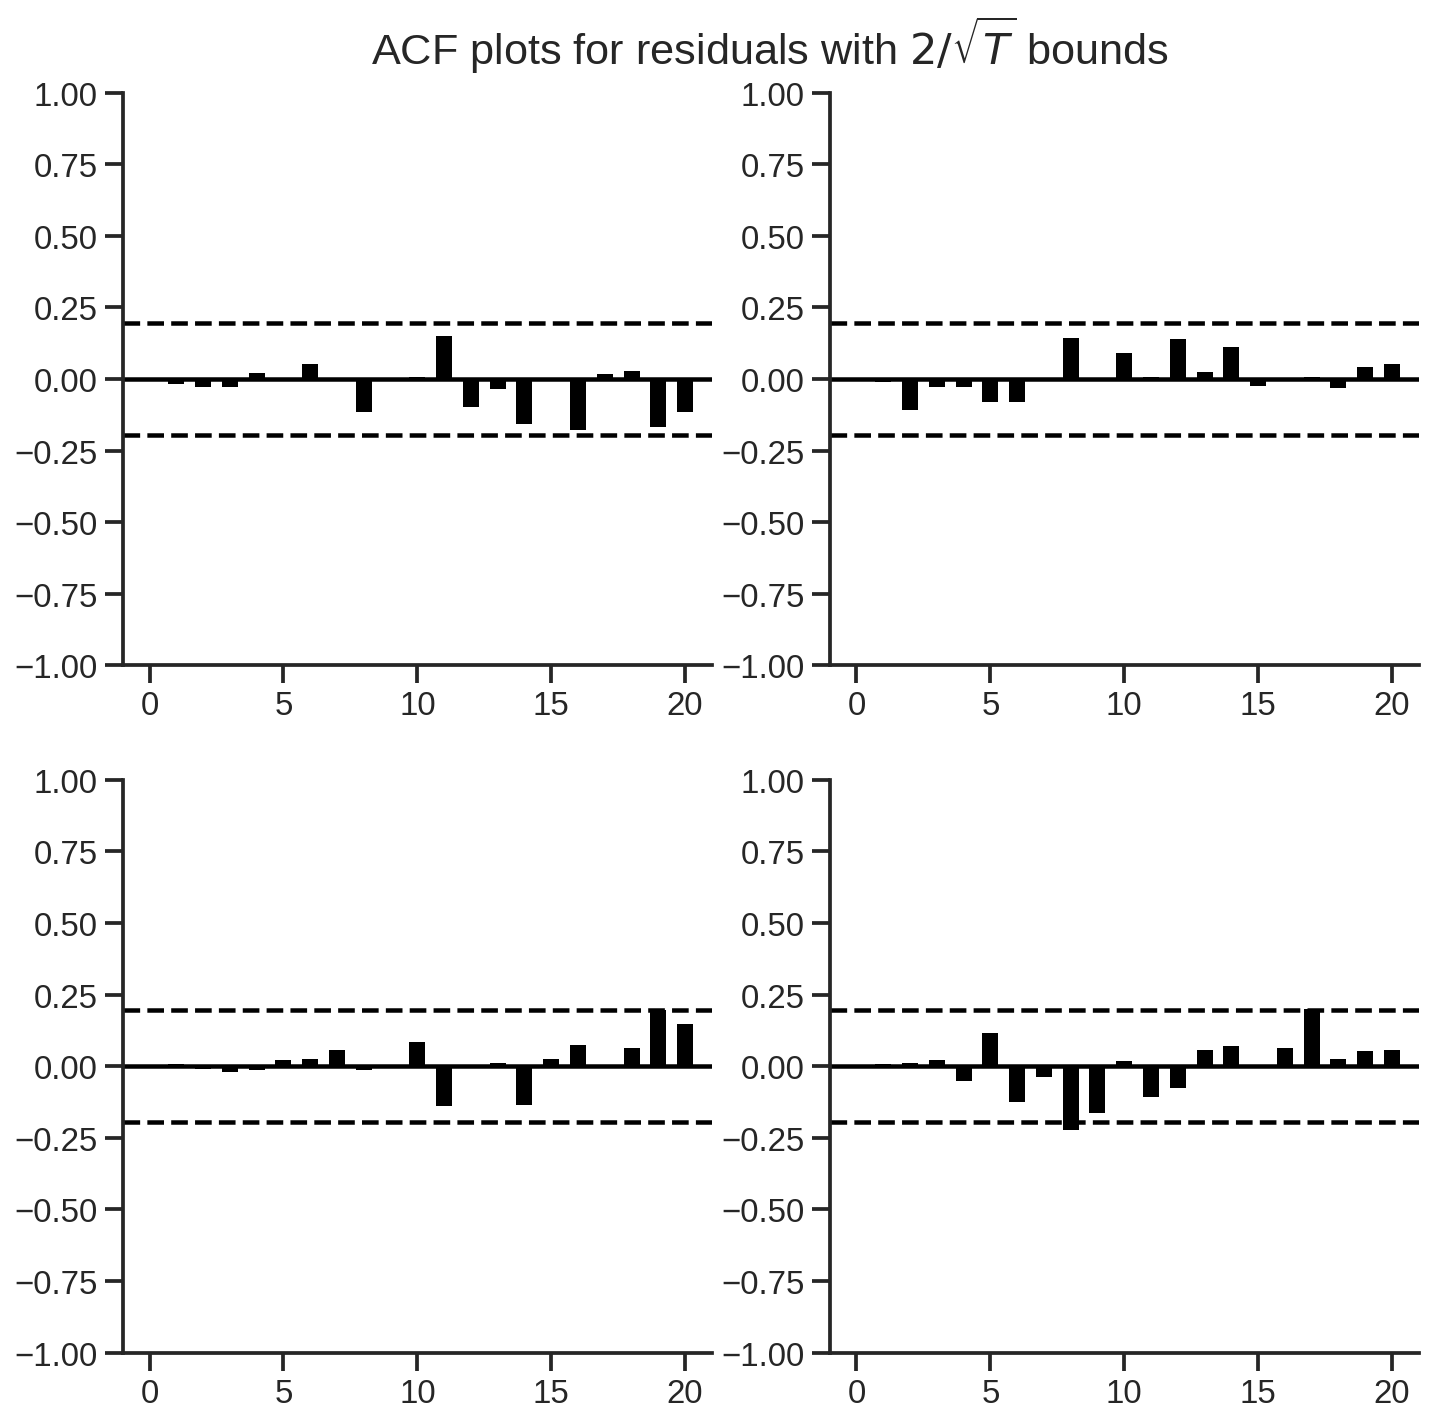

In [30]:
results.plot_acorr(nlags = 20)
sns.despine()
plt.show()

**Conclusão:** Pela inspeção gráfica, o modelo não apresenta autocorrelação serial dos resíduos.

### Estabilidade

In [31]:
print("Estável:", results.is_stable(verbose=True))

Eigenvalues of VAR(1) rep
0.761468453138499
0.8105694993103912
0.8105694993103912
0.7273110389497105
0.7273110389497105
0.868490618964099
0.868490618964099
0.4874517979899699
0.42915050852632836
0.42915050852632836
Estável: True


**OBS:** Apesar de estar escrito VAR(1), os resultados acima correspondem ao VAR(p)

## Inspeção dos resíduos

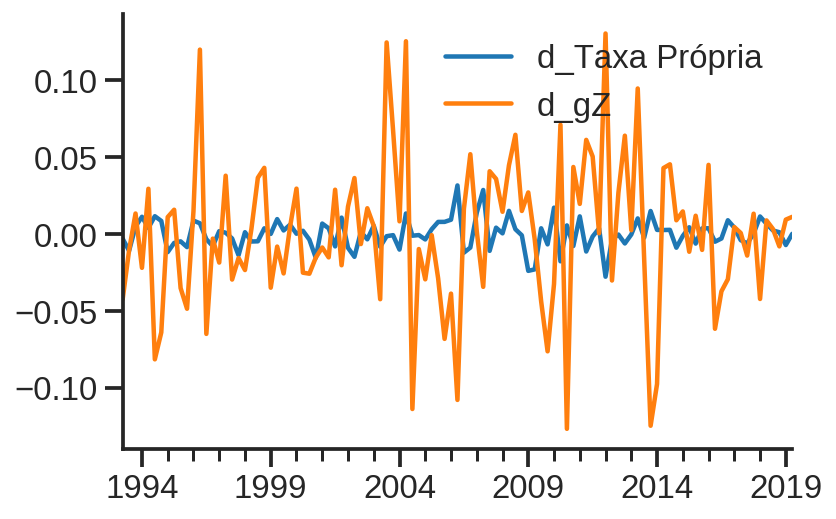

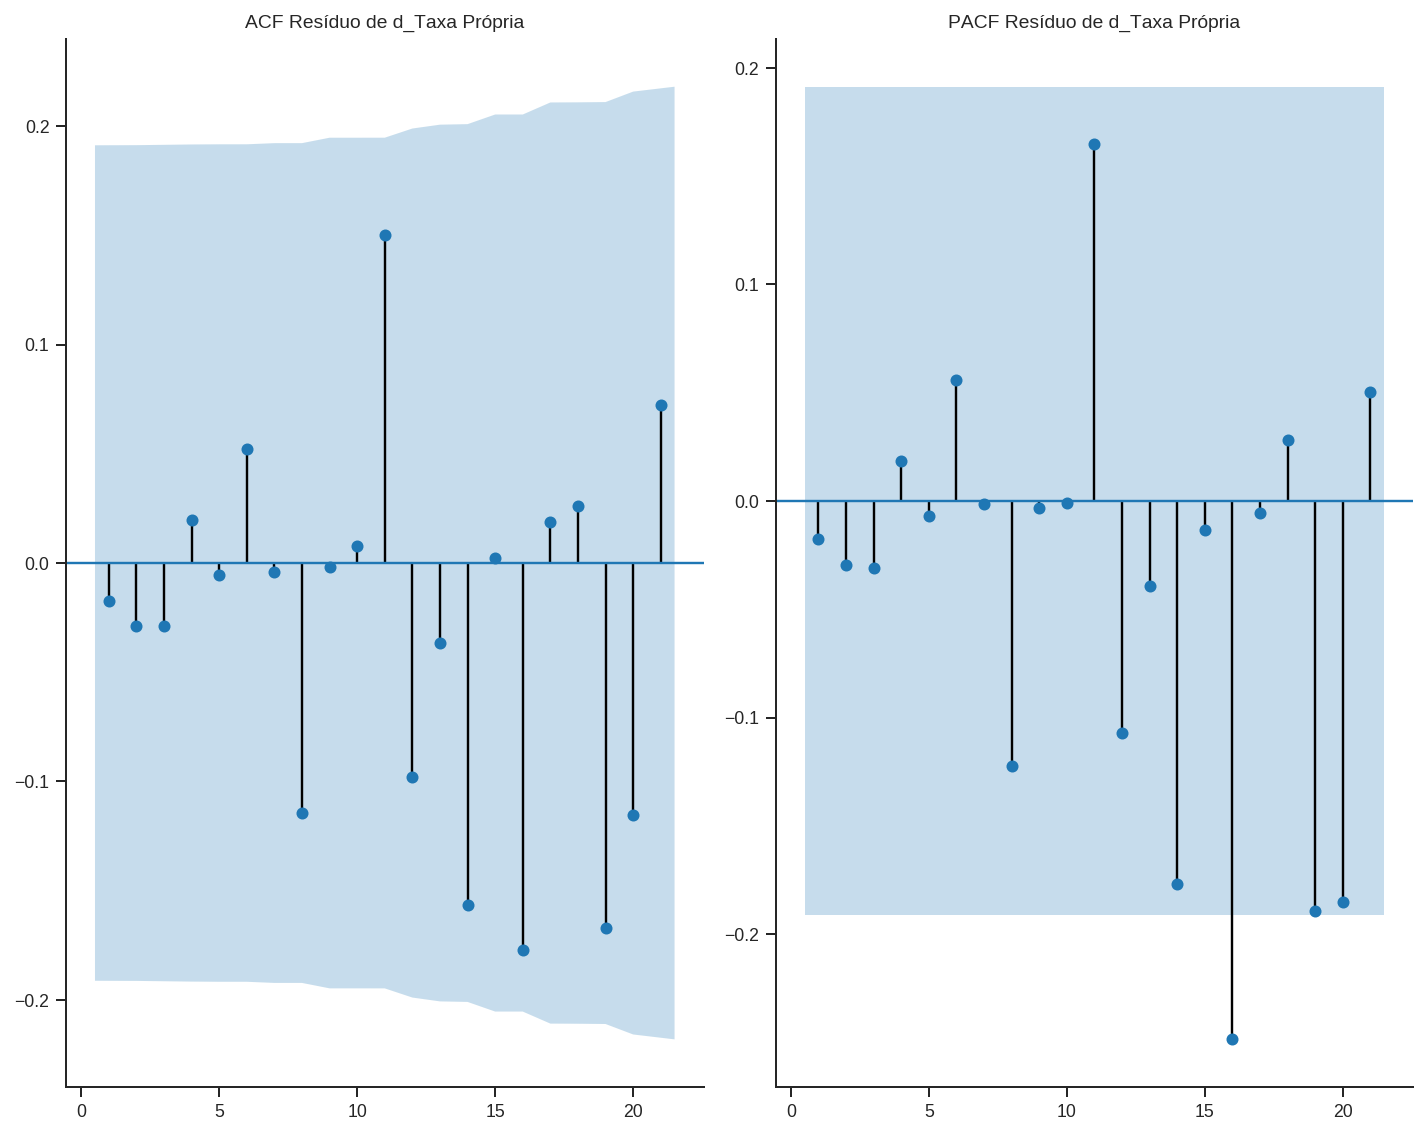

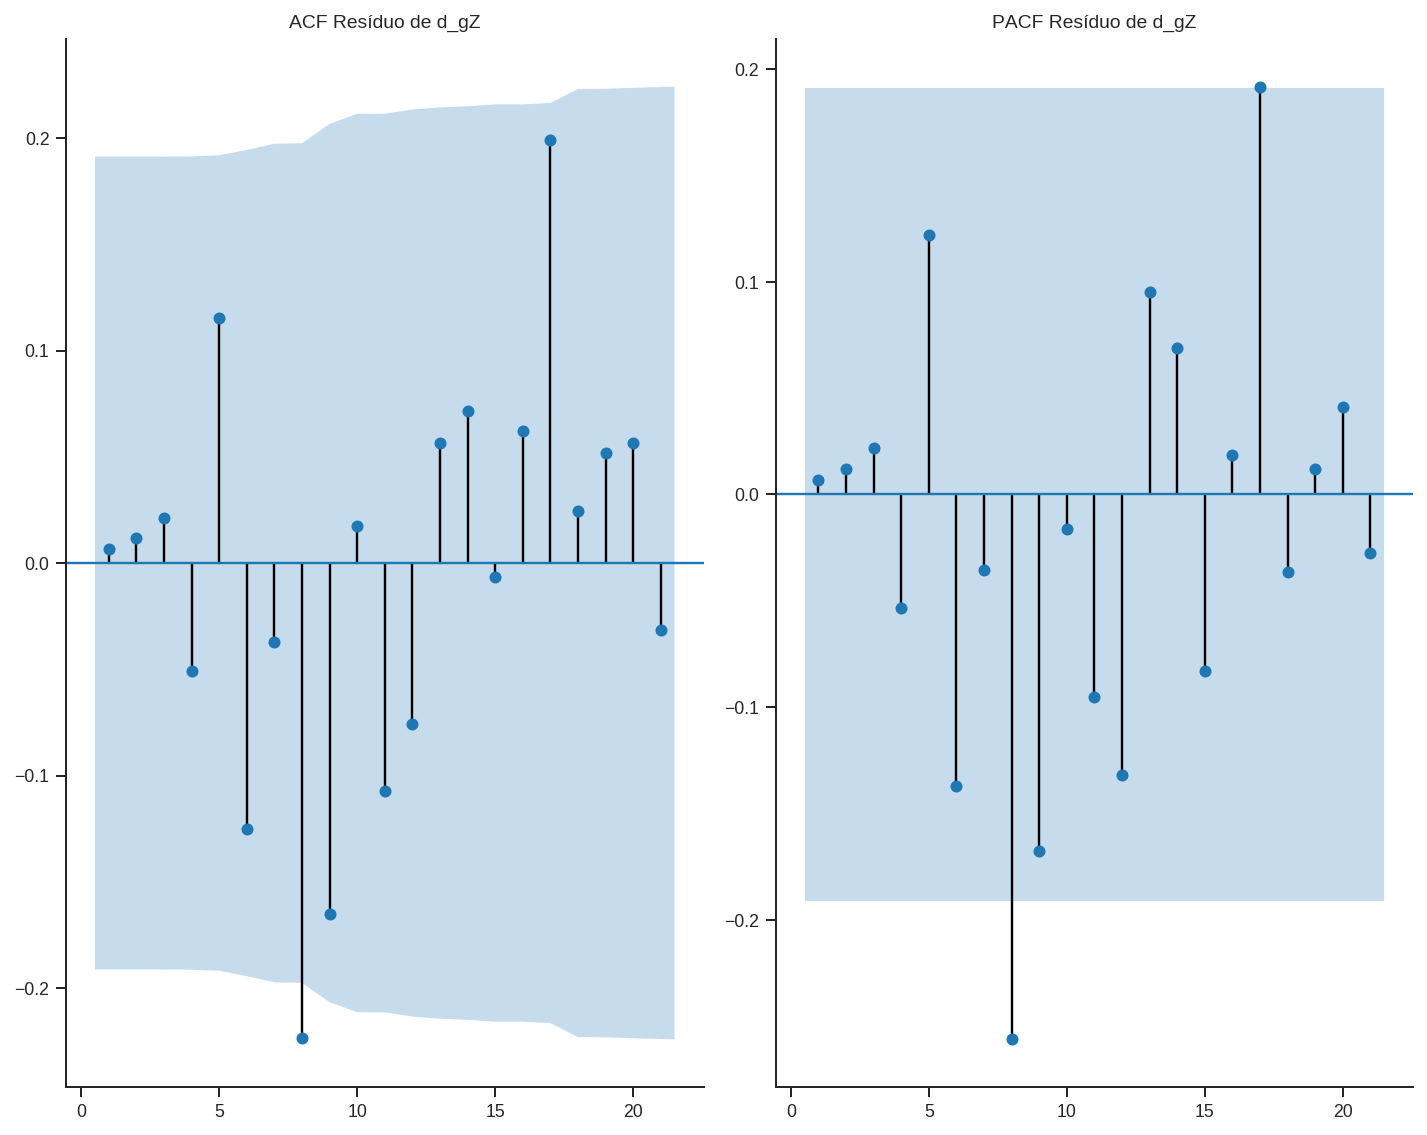

AUTOCORRELAÇÃO RESIDUAL: PORTMANTEAU

Portmanteau-test for residual autocorrelation. H_0: residual autocorrelation up to lag 15 is zero. Conclusion: fail to reject H_0 at 5% significance level.
Test statistic Critical value p-value df
----------------------------------------
         38.34          55.76   0.545 40
----------------------------------------

AUTOCORRELAÇÃO RESIDUAL: PORTMANTEAU AJUSTADO

Adjusted Portmanteau-test for residual autocorrelation. H_0: residual autocorrelation up to lag 15 is zero. Conclusion: fail to reject H_0 at 5% significance level.
Test statistic Critical value p-value df
----------------------------------------
         42.18          55.76   0.377 40
----------------------------------------

LJUNGBOX

H0: autocorrelations up to lag k equal zero
H1: autocorrelations up to lag k not zero
Box-Pierce:  False
Testing for  D_TAXA PRÓPRIA . Considering a significance level of 5.0 %
p-value = 0.9436571422022301
Reject H0 on lag  1 ?  False 

p-value = 0.99018

In [32]:
residuals = analise_residuos(results=results)

## Inspeção gráfica dos resíduos

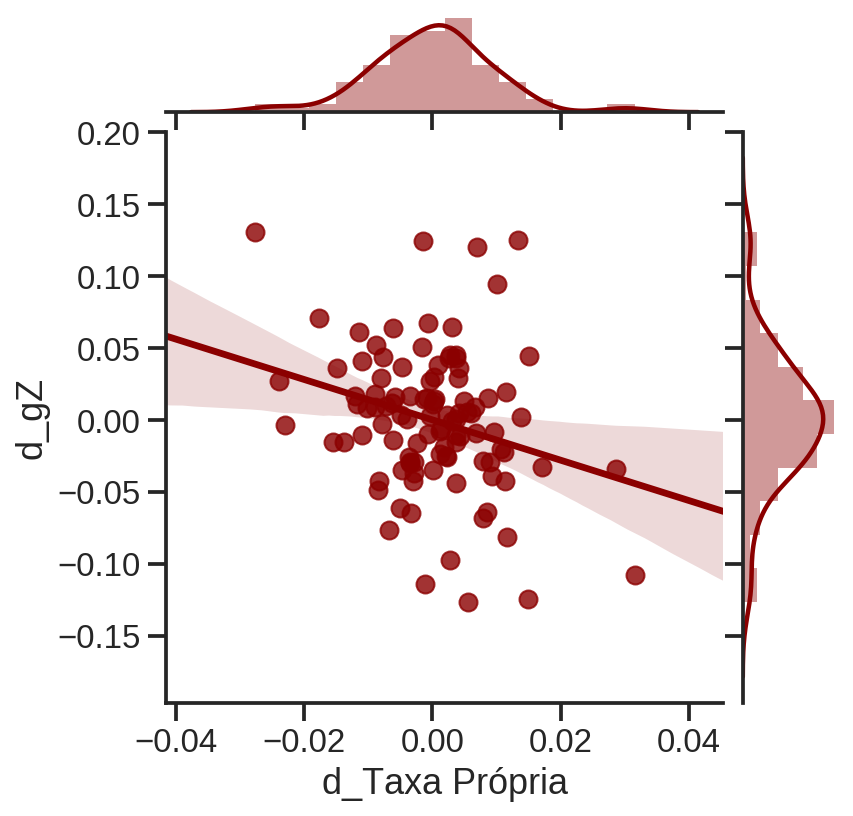

In [33]:
series = results.names
sns.set_context('talk')
ax = sns.jointplot(
    x = series[0], 
    y = series[1], 
    data = residuals, color = 'darkred', kind="reg", 
)
plt.show()

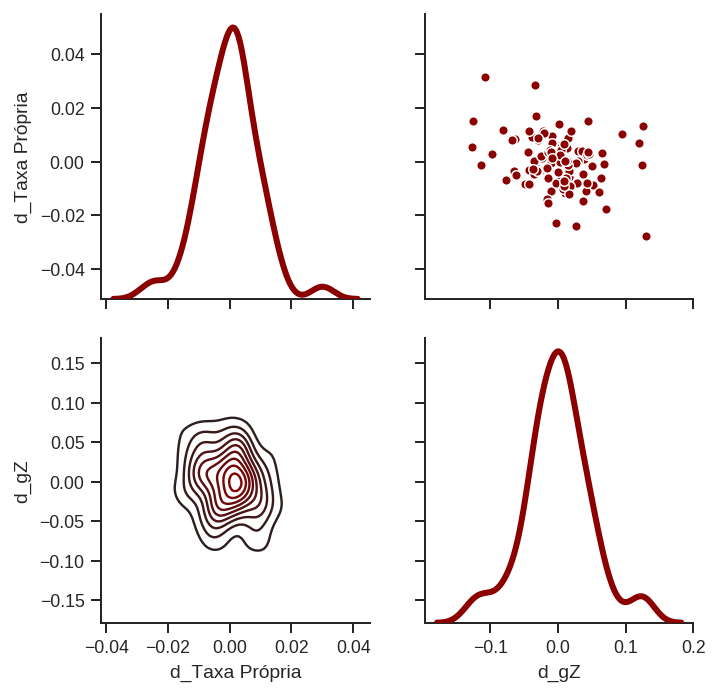

In [34]:
sns.set_context('paper')
g = sns.PairGrid(residuals, diag_sharey=False)
g.map_lower(sns.kdeplot, color = 'darkred')
g.map_upper(sns.scatterplot, color = 'darkred')
g.map_diag(sns.kdeplot, lw=3, color = 'darkred')
plt.show()
g.savefig("./figs/Residuos_4.png", dpi=300)

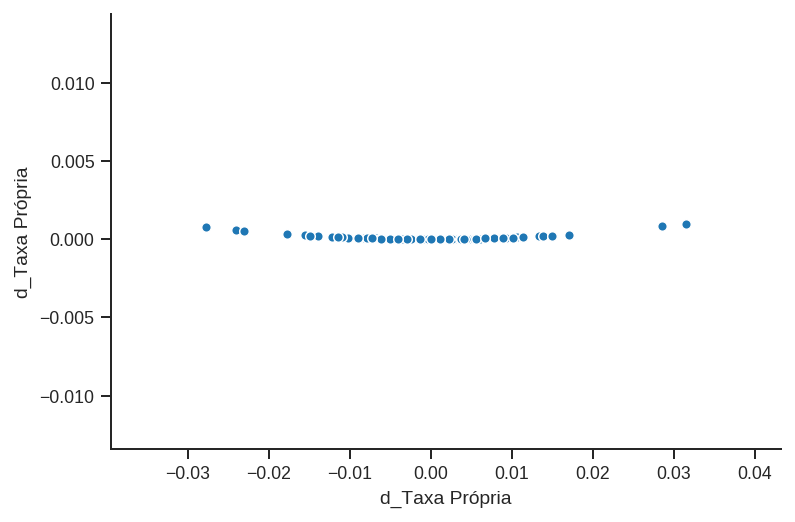

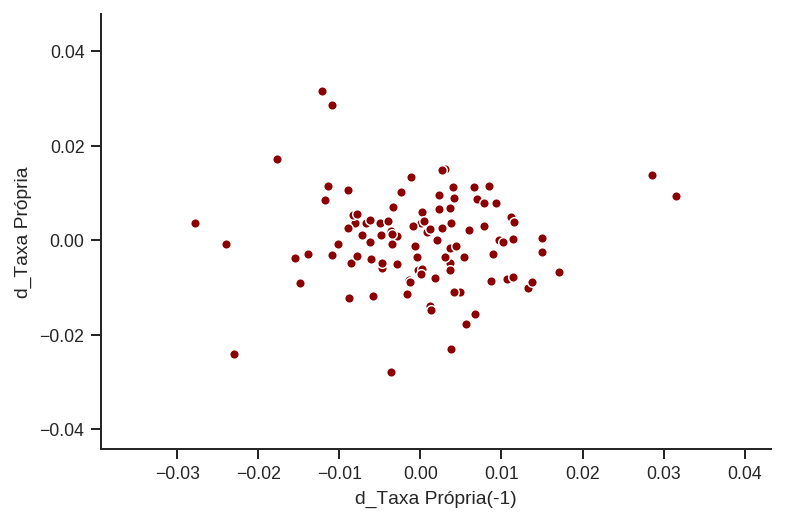

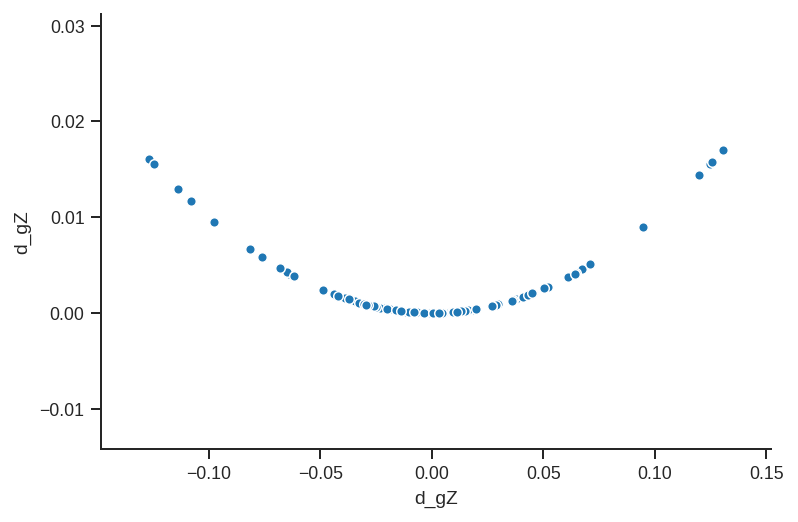

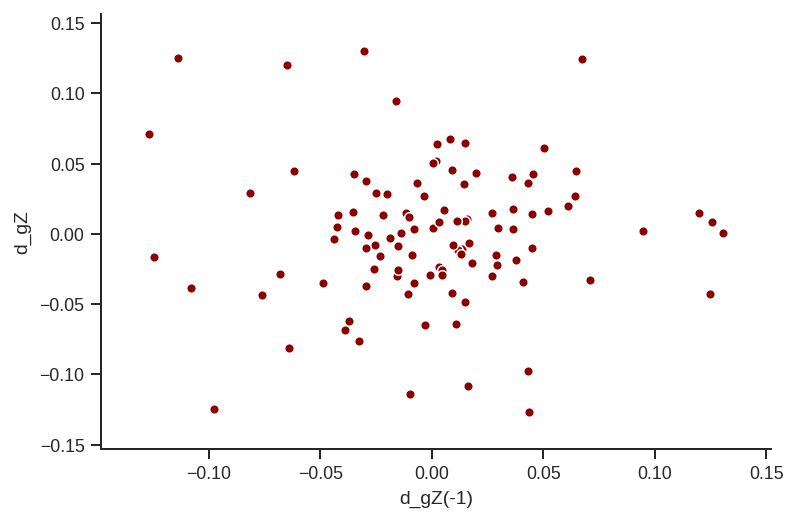

In [35]:
series = results.names
for serie in series:
    sns.scatterplot(x = residuals[serie], y = residuals[serie]**2)
    sns.despine()
    plt.show()
    
    sns.scatterplot(
    y = residuals[serie], 
    x = residuals[serie].shift(-1), 
    color = 'darkred' 
    )
    sns.despine()
    plt.xlabel(f"{serie}(-1)")
    plt.show()

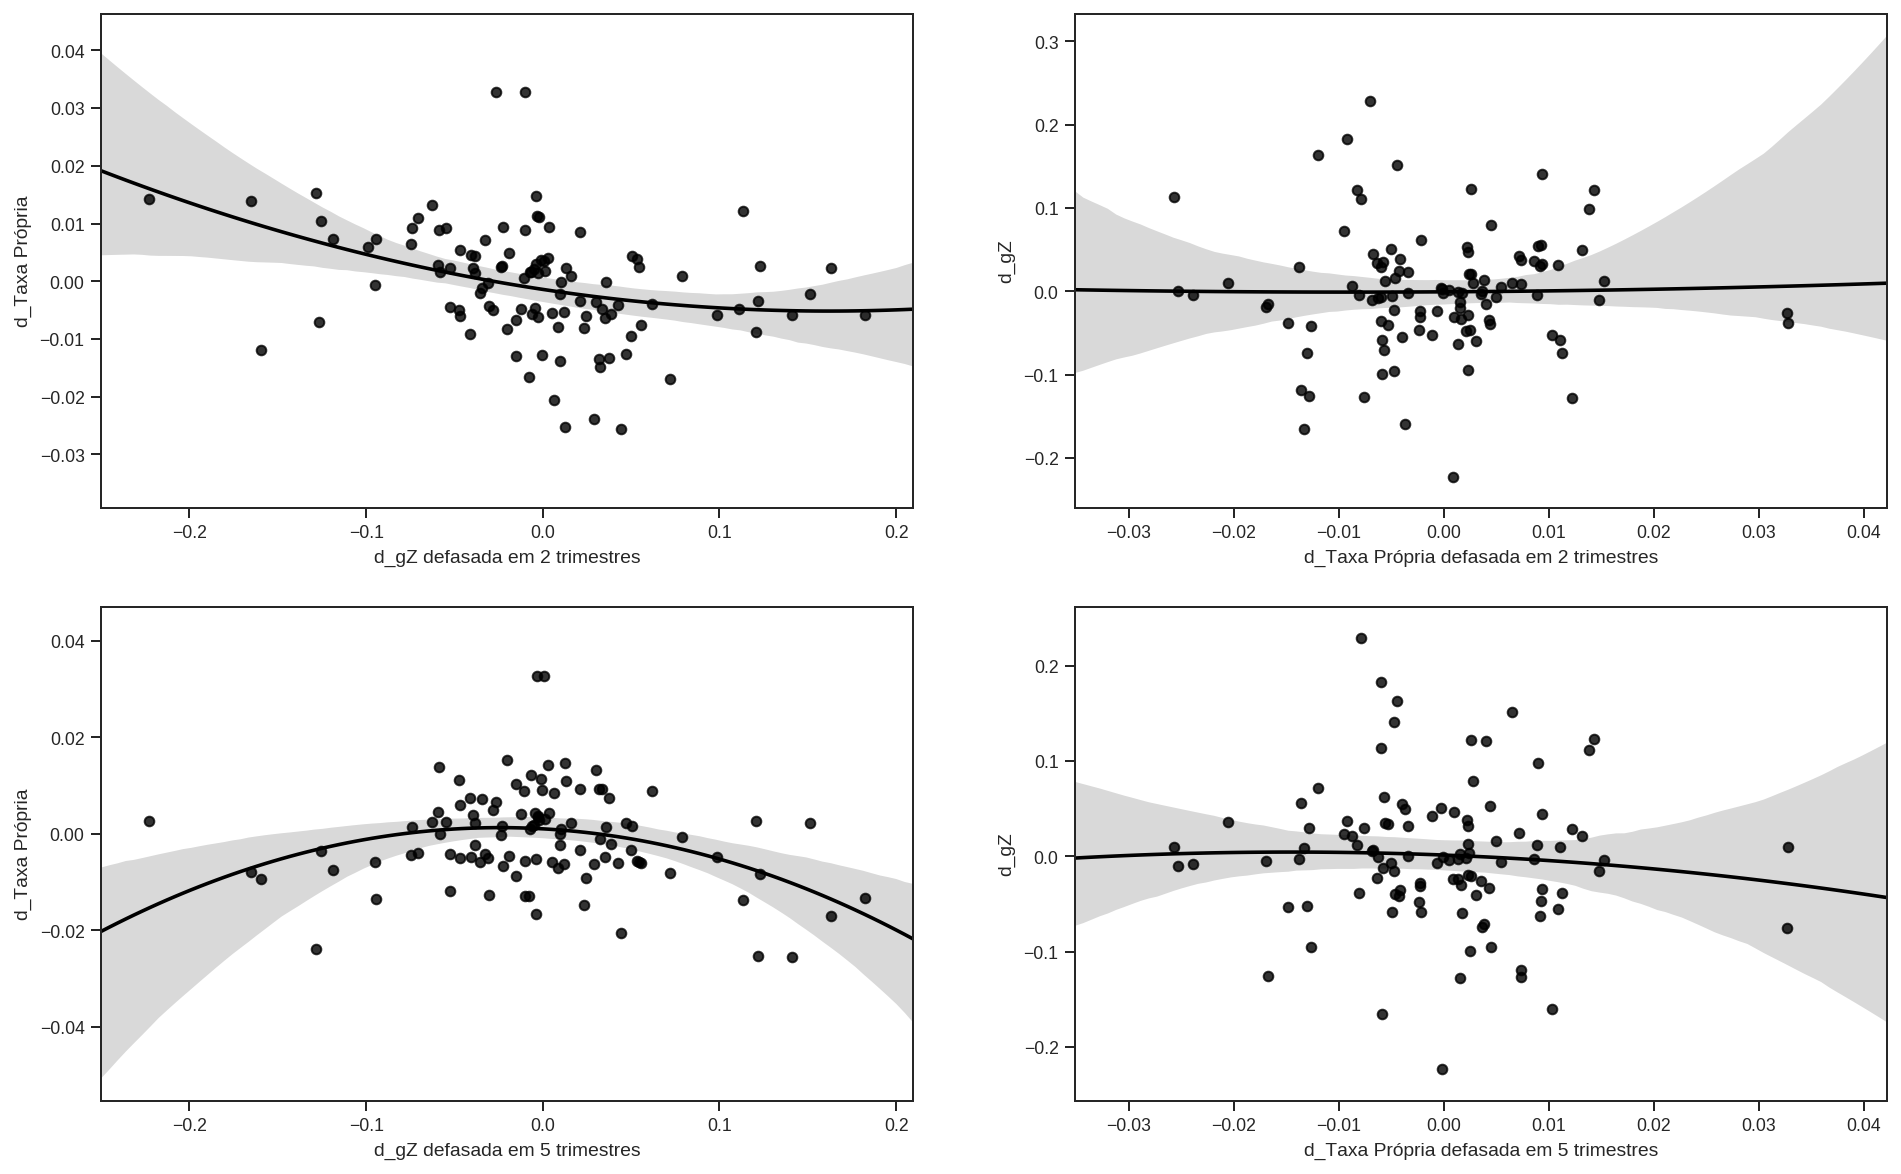

In [36]:
plot_lags(results=results)

## Função resposta ao impulso ortogonalizada

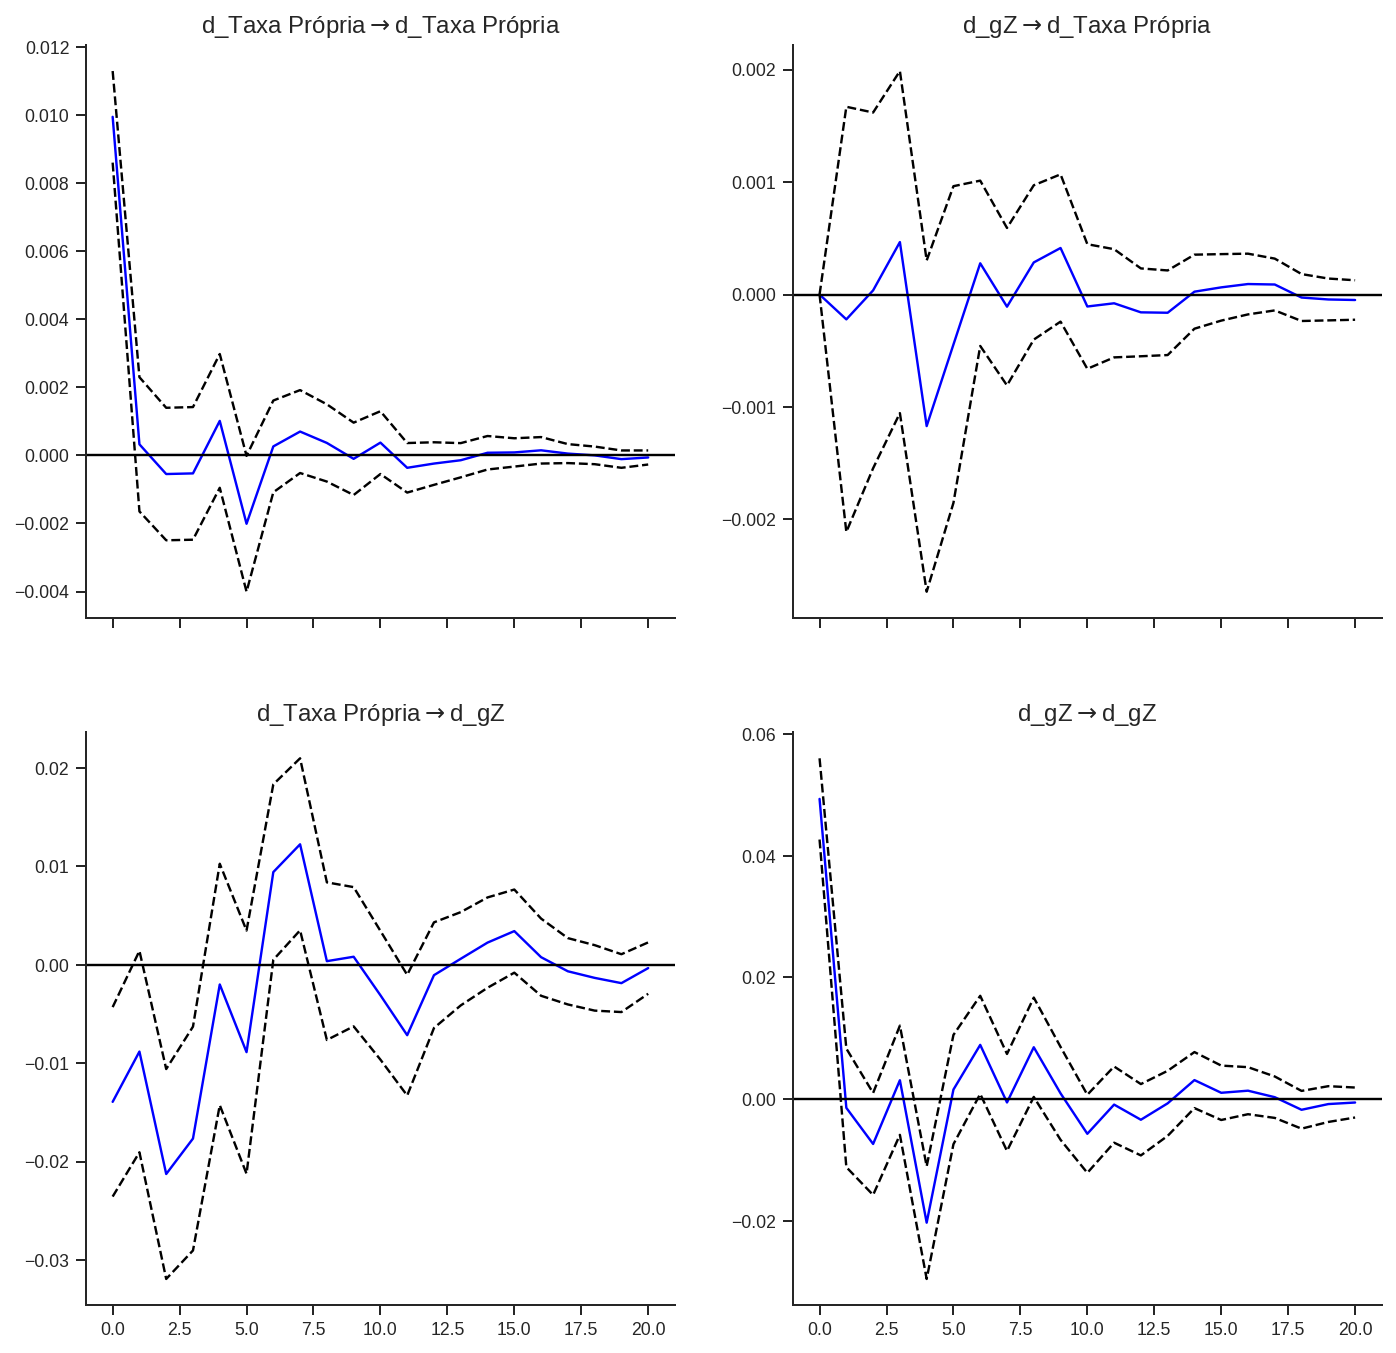

In [37]:
p = results.irf(20).plot(orth=True)
p.suptitle("")
sns.despine()
plt.show()
p.savefig("./figs/Impulso_Orth.png", dpi = 300)

## Função resposta ao impulso não-ortogonalizada

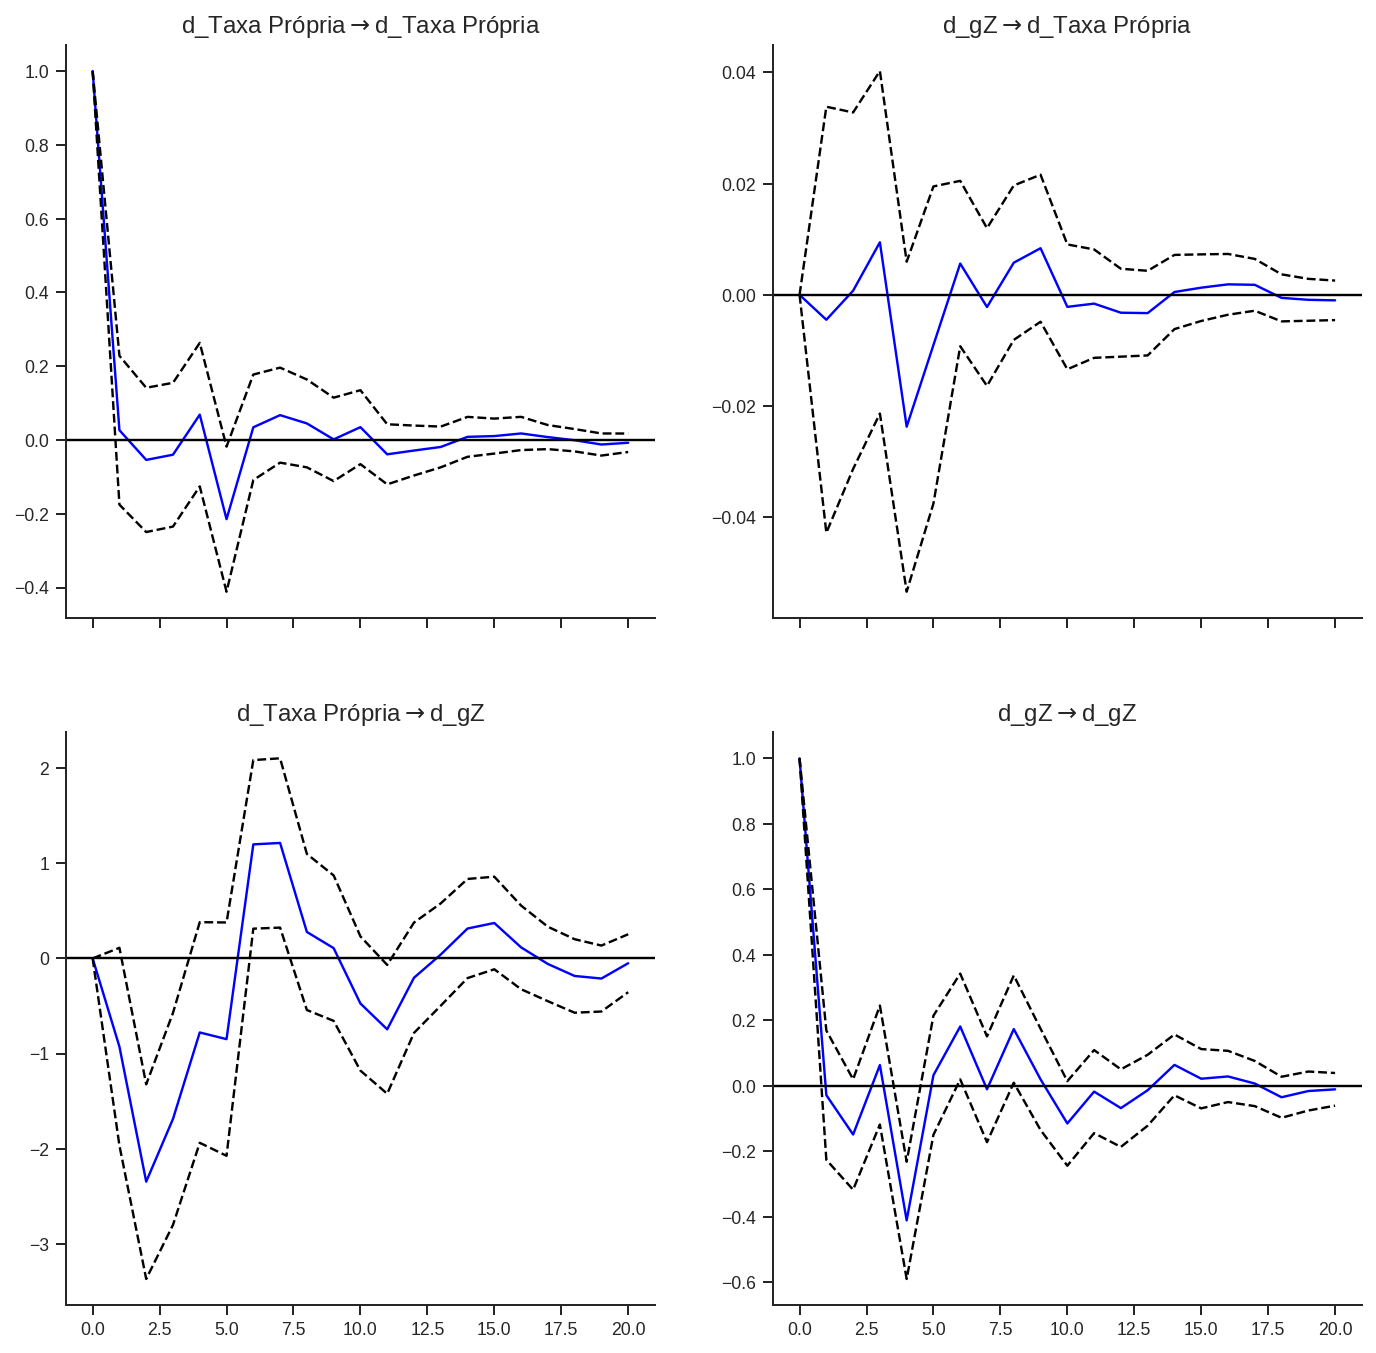

In [38]:
p = results.irf(20).plot(orth=False)
p.suptitle("")
sns.despine()
plt.show()
p.savefig("./figs/Impulso.png", dpi = 300)

## Efeito cumulativo

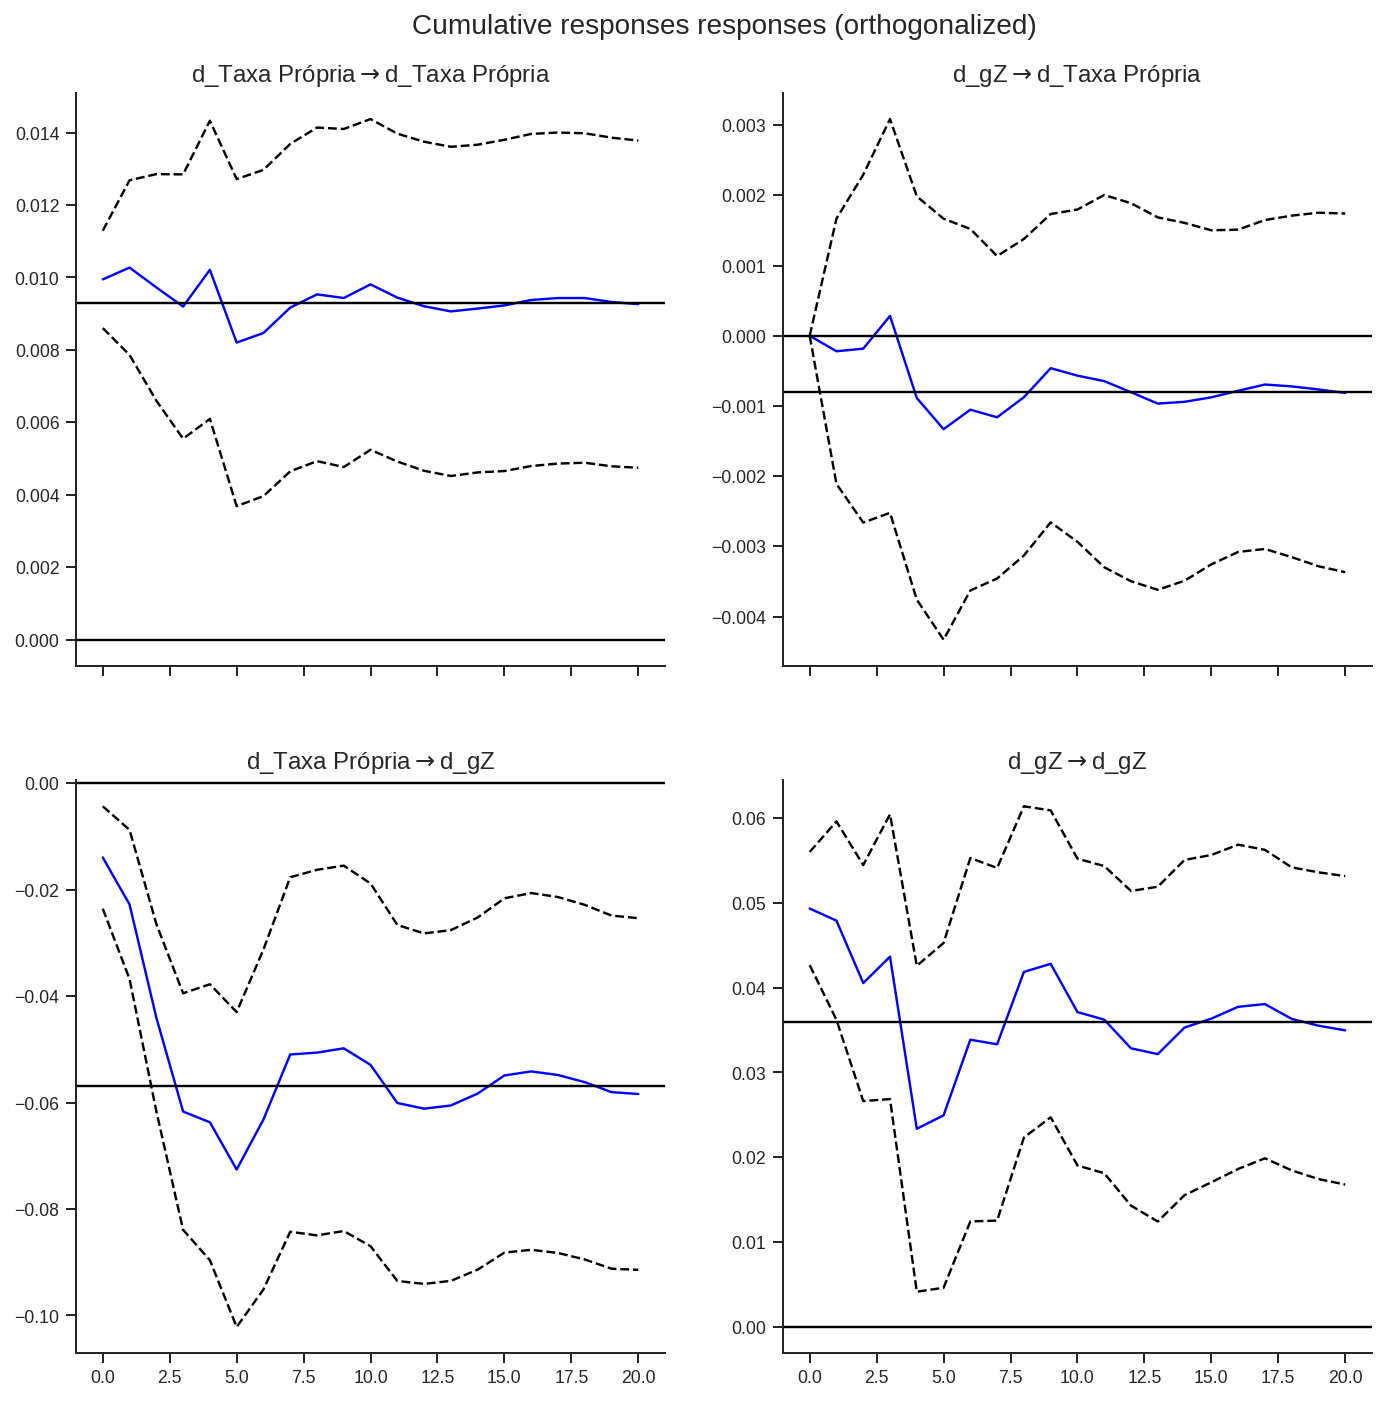

In [39]:
p = results.irf(20).plot_cum_effects(orth=True)
sns.despine()
plt.show()
p.savefig("./figs/Impulso_Cum.png", dpi = 300)

## Decomposição da variância

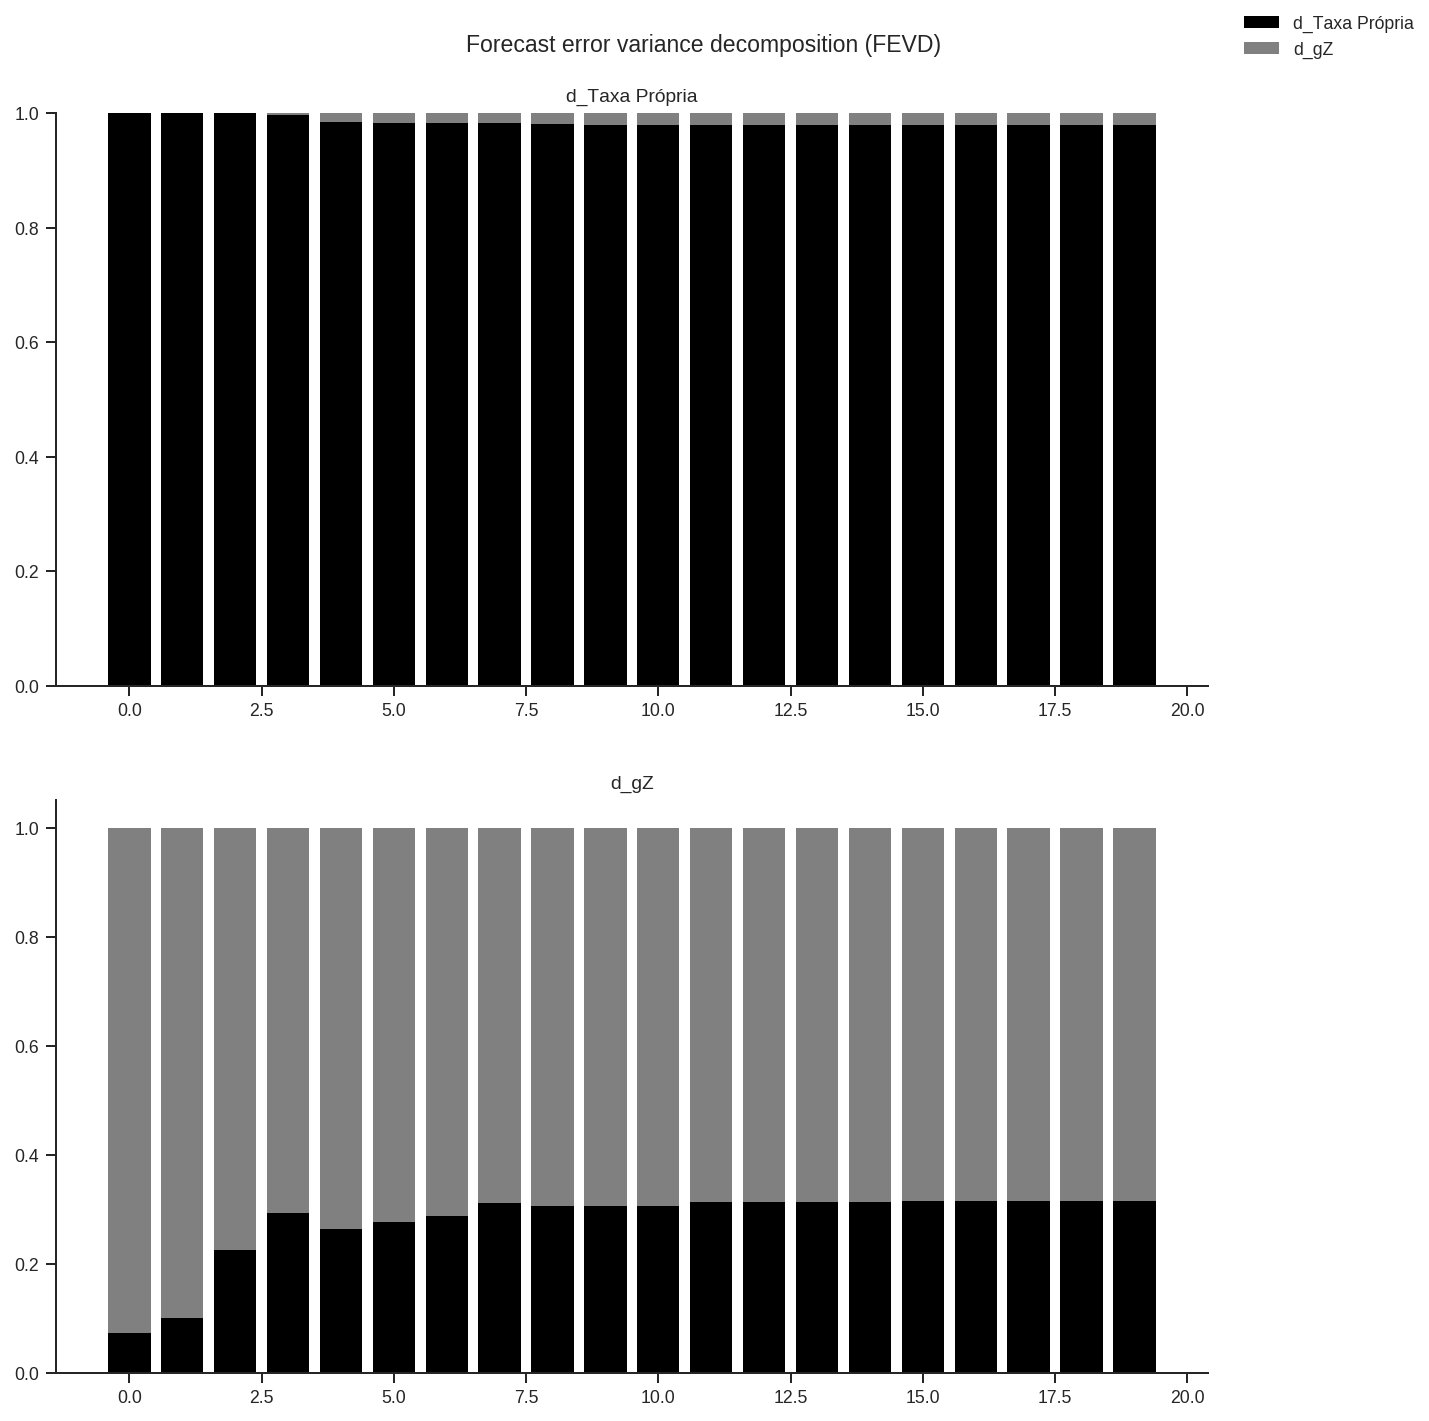

In [40]:
p = results.fevd(20).plot()
sns.despine()
plt.show()
p.savefig("./figs/DecompVar.png", dpi = 300)